In [2]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

Note you need this `decomposition.py` script.

In [3]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py
%run decomposition.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Get Data

In [4]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [5]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

In [6]:
hydrocat620

,DateTime,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C)
0,2022-01-04 09:31:15.400,6.5078,30.7871,9.592,7.934479,7.478,7.934479,7.797240
1,2022-01-04 10:46:15.400,6.3631,30.8278,9.663,7.934814,1.844,7.934814,7.795139
2,2022-01-04 11:01:15.200,6.3063,30.7459,9.633,7.934773,2.373,7.934773,7.794166
3,2022-01-04 11:16:15.200,6.2367,30.7015,9.680,7.934821,3.158,7.934821,7.793057
4,2022-01-04 11:31:15.200,6.2593,30.6492,9.698,7.924688,2.170,7.924688,7.783583
...,...,...,...,...,...,...,...,...
34421,2023-04-30 22:46:29.000,11.7928,28.4188,8.547,7.971222,0.021,7.971222,7.920264
34422,2023-04-30 23:01:29.000,11.7991,28.4178,8.472,7.961210,0.020,7.961210,7.910442
34423,2023-04-30 23:16:29.000,11.8380,28.3284,8.471,7.971013,0.021,7.971013,7.920790
34424,2023-04-30 23:31:29.000,11.9170,28.1962,8.406,7.970686,0.020,7.970686,7.921743


# Weather Data
I wrote the functions for the decomposition thing to have wind as an optional input. I used actual wind data in this version.
## PLT

In [7]:
MetData_PLT = PLT.get_buoy('2022-01-01', '2023-07-01','PLT','MetData')

In [8]:
met_PLT = pd.DataFrame(MetData_PLT) 
met_PLT = met_PLT.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)
met_PLT

,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation,DateTime
0,1.176740,238.703,2.191290,222.4200,8.6,0.0,2022-01-01 00:00:00
1,0.982541,229.899,2.133050,220.3470,8.4,0.0,2022-01-01 00:10:00
2,0.321709,228.680,0.776346,231.6590,8.4,0.0,2022-01-01 00:20:00
3,0.650487,192.874,0.987254,179.1100,8.6,0.0,2022-01-01 00:30:00
4,0.277924,359.750,1.629940,17.6544,7.9,0.0,2022-01-01 00:40:00
...,...,...,...,...,...,...,...
72710,2.191040,194.006,3.103230,192.3210,20.5,0.0,2023-06-30 23:10:00
72711,2.307460,197.082,2.879900,188.3290,20.6,0.0,2023-06-30 23:20:00
72712,2.207490,206.130,2.892030,220.3490,20.7,0.0,2023-06-30 23:30:00
72713,2.980040,218.227,3.952450,224.5870,20.8,0.0,2023-06-30 23:40:00


In [9]:
for k in met_PLT.keys():
    if k == 'DateTime':
        met_PLT[k] = pd.to_datetime(met_PLT[k], format = '%Y-%m-%D %H:%M:%S')

### PLT to Hydrocat 620

In [10]:
hydrocat620 = pd.merge_asof(hydrocat620, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)

### PLT to QP

In [11]:
QP = pd.merge_asof(QP, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
QP = QP.reset_index(drop=True)

## GB

In [12]:
MetData_GB = PLT.get_buoy('2022-01-01', '2023-07-01','GB','MetData')

In [13]:
met_GB = pd.DataFrame(MetData_GB) 
met_GB = met_GB.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)
met_GB

,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation,DateTime
0,0.936771,349.553000,1.65960,322.691,7.1,0.0,2022-01-01 00:00:00
1,1.127380,336.847000,1.77327,324.336,7.0,0.0,2022-01-01 00:10:00
2,1.001410,0.220732,1.38000,359.000,7.0,0.0,2022-01-01 00:20:00
3,1.506670,0.166002,1.73923,358.337,6.9,0.0,2022-01-01 00:30:00
4,1.295750,4.968490,1.73643,357.660,6.9,0.0,2022-01-01 00:40:00
...,...,...,...,...,...,...,...
77244,3.992220,205.859000,5.15074,206.515,21.0,0.0,2023-06-30 23:10:00
77245,3.558400,211.066000,5.59082,194.977,21.0,0.0,2023-06-30 23:20:00
77246,3.462170,219.634000,4.30473,219.243,21.1,0.0,2023-06-30 23:30:00
77247,3.666640,219.962000,4.43232,210.267,21.0,0.0,2023-06-30 23:40:00


In [14]:
for k in met_GB.keys():
    if k == 'DateTime':
        met_GB[k] = pd.to_datetime(met_GB[k], format = '%Y-%m-%D %H:%M:%S')

### GB to Hydrocat 720

In [15]:
hydrocat720 = pd.merge_asof(hydrocat720, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat720 = hydrocat720.reset_index(drop=True)

### GB to MV

In [16]:
MV = pd.merge_asof(MV, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
MV = MV.reset_index(drop=True)

# Decomposition using `decomposition.py`
`decomposition.decomposition(df,t)` gives 2 outputs: a dataframe with the individual components and a dataframe with the associated errors.

You can select the timescale over which it averages. So for special events, you might pick 'D' for daily. Note you will have to narrow down your dataset by time prior to doing this.

In [17]:
[comp620, std620] = decomposition.decomposition(hydrocat620, 'M', location = 'PLT')
[comp720, std720] = decomposition.decomposition(hydrocat720, 'M', location = 'GB')
[compMV, stdMV] = decomposition.decomposition(MV, 'M', location = 'GB')
[compQP, stdQP] = decomposition.decomposition(QP, 'M', location = 'PLT')

In [18]:
comp720.iloc[1] = np.nan
std720.iloc[1] = np.nan
std720

,DateTime,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,,
2022-01-31,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000257,NaN,NaN,NaN
2022-02-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,2022-03-31,0.000481,6.954616e-04,-0.006518,-0.000396,0.006749,-0.002796,0.001586,0.002824,0.009382,0.009962
2022-04-30,2022-04-30,0.000413,2.527203e-04,-0.002718,0.000004,0.002790,0.000029,0.000340,0.000030,0.003896,0.003940
2022-05-31,2022-05-31,0.000564,1.411716e-04,-0.001694,0.000108,0.001727,0.000752,-0.000383,0.000759,0.002419,0.002629
2022-06-30,2022-06-30,0.000520,1.044955e-05,-0.000144,0.000197,0.000146,0.001363,-0.000891,0.001377,0.000205,0.001733
2022-07-31,2022-07-31,0.000615,8.695185e-05,-0.001110,0.000233,0.001130,0.001618,-0.002295,0.001635,0.001584,0.003292
2022-08-31,2022-08-31,0.000031,3.557639e-05,-0.000513,0.000331,0.000518,0.002282,-0.001772,0.002306,0.000729,0.002999
2022-09-30,2022-09-30,-0.000565,-1.515956e-04,0.002442,0.000811,-0.002445,0.005535,-0.004434,0.005594,0.003456,0.007952


In [19]:
comp620['DIC air sea flux'].iloc[5] = np.nan
std620['DIC ASF'].iloc[5] = np.nan
comp620

,DateTime,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC_bio,DIC air sea flux,Total bio,Total mixing,Total
DateTime,,,,,,,,,,,
2022-01-31,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.001339,NaN,NaN,NaN
2022-02-28,2022-02-28,0.000118,-0.000207,0.002072,-0.000400,-0.002128,-0.002800,0.001920,-0.003199,-0.000056,-0.001424
2022-03-31,2022-03-31,0.000572,-0.000015,0.000170,0.000010,-0.000173,0.000072,0.001003,0.000082,-0.000003,0.001639
2022-04-30,2022-04-30,0.000815,0.000076,-0.000905,0.000063,0.000920,0.000434,0.000053,0.000497,0.000015,0.001457
2022-05-31,2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-31,2022-07-31,0.001444,0.000147,-0.001865,0.000783,0.001898,0.005436,-0.006420,0.006219,0.000033,0.001424
2022-08-31,2022-08-31,0.000045,0.000142,-0.001819,0.000984,0.001850,0.006820,-0.006619,0.007803,0.000030,0.001402
2022-09-30,2022-09-30,-0.000926,-0.000141,0.001802,0.000883,-0.001831,0.006121,-0.005931,0.007004,-0.000029,-0.000023


In [20]:
compQP['DIC air sea flux'].iloc[0] = np.nan
comp620['DIC air sea flux'].iloc[0] = np.nan
comp620['DIC air sea flux'].iloc[0] = np.nan
comp720['DIC air sea flux'].iloc[0] = np.nan
compMV['DIC air sea flux'].iloc[0] = np.nan

In [21]:
stdQP['DIC ASF'].iloc[0] = np.nan
std620['DIC ASF'].iloc[0] = np.nan
std720['DIC ASF'].iloc[0] = np.nan
stdMV['DIC ASF'].iloc[0] = np.nan

In [40]:
purple = '#6a4c93'
blue = '#1982c4'
green = '#8ac926'
yellow = '#ffca3a'
red = '#FF595E'
pink = '#ff6289'

In [23]:
pink = '#ff6289'
purple = '#C79FEF'
blue = '#82e9ff'
green = '#C1F80A'

# Greens
caribbean_green = '#00cc99'
emerald = '#319177'
crayola_green = '#1cac78'
jade = '#00a86b'
kelly = '#4cbb17'
yellowgreen = '#9acd32'

# Blues
french_sky_blue = '#77b5fe'
opal = '#a8c3bc'
baby_blue = '#89cff0'
tiffany_blue = '#0abab5'
cornflower = '#6495ed'

# Pinks
hollywood_cerise = '#f400a1'
baker_miller = '#ff91af'
wild_strawberry = '#ff43a4'

# Purples
iris = '#5a4fcf'
orchid = '#9932cc'
amethyst = '#9966cc'
wisteria = '#c9a0dc'

# Oranges
neon_carrot = '#ffa343'
gamboge = '#e49b0f'
carrot = '#ed9121'

# Yellows
sunglow = '#ffcc33'
bitter_lemon = '#cae00d'
pantone_yellow = '#fedf00'

# Reds
candy_apple = '#e2062c'
carmine = '#eb4c42'
coquelicot = '#ff3800'

clr_hydro620 = caribbean_green

clr_hydro720 = cornflower

clr_MV = baker_miller

clr_QP = pantone_yellow

clr_PLT = wisteria

clr_GB = neon_carrot

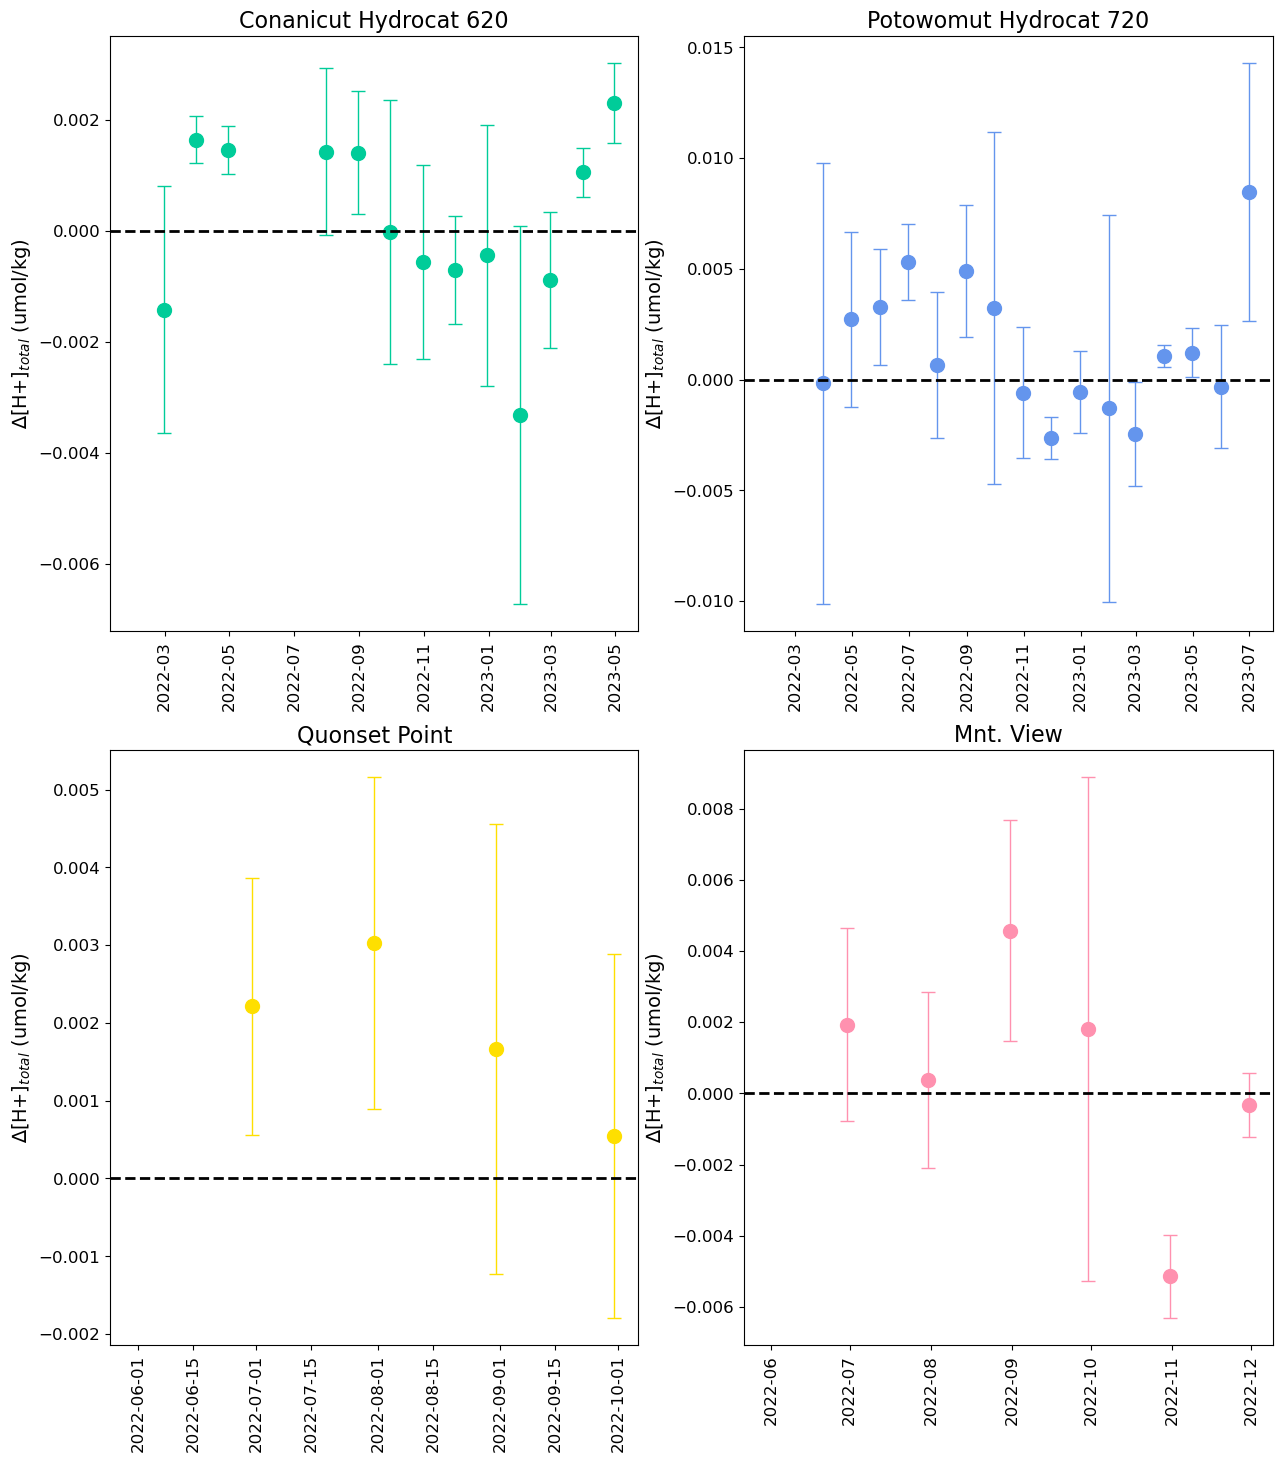

In [53]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [15,17])
axarr = axarr.flatten()

ax = axarr[0]
ax.errorbar(comp620['DateTime'],comp620['Total'], yerr = std620['Total error'],
            fmt='o',capsize = 5, color = clr_hydro620, lw = 1, capthick = 1, markersize = 10, zorder = 1)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+]$_{total}$ (umol/kg)', fontsize = 14)
ax.set_title('Conanicut Hydrocat 620', fontsize = 16)

ax = axarr[1]
ax.errorbar(comp720.index,comp720['Total'], yerr = std720['Total error'],
            fmt='o',capsize = 5, color = clr_hydro720, lw = 1, capthick = 1, markersize = 10, zorder = 1)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+]$_{total}$ (umol/kg)', fontsize = 14)
ax.set_title('Potowomut Hydrocat 720', fontsize = 16)

ax = axarr[2]
ax.errorbar(compQP['DateTime'],compQP['Total'], yerr = stdQP['Total error'],
            fmt='o',capsize = 5, color = clr_QP, lw = 1, capthick = 1, markersize = 10, zorder = 1)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+]$_{total}$ (umol/kg)', fontsize = 14)
ax.set_title('Quonset Point', fontsize = 16)

ax = axarr[3]
ax.errorbar(compMV['DateTime'],compMV['Total'], yerr = stdMV['Total error'],
            fmt='o',capsize = 5, color = clr_MV, lw = 1, capthick = 1, markersize = 10,  zorder = 1)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+]$_{total}$ (umol/kg)', fontsize = 14)
ax.set_title('Mnt. View', fontsize = 16)

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/total_dH.png', bbox_inches='tight')

# Hydrocat 620

Text(7.5, -0.004, 'H+ decreases\npH increases.')

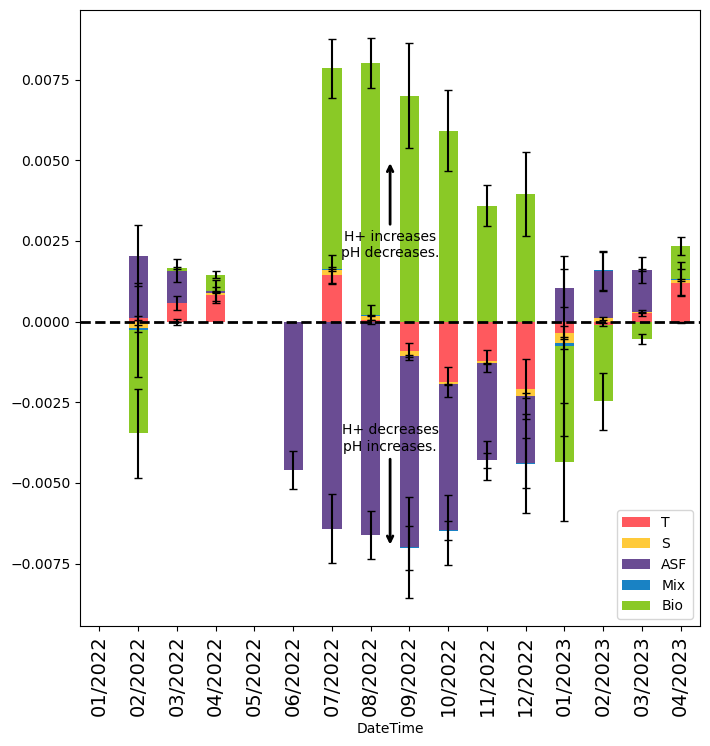

In [55]:
df = comp620
dt = std620
title = 'Hydrocat 620'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])

fig, ax = plt.subplots(figsize = [8,8])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.legend(loc = 'lower right')


plt.annotate('H+ increases\npH decreases.',
             xy=(7.5,0.005),
             xytext=(7.5, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

plt.annotate('H+ decreases\npH increases.',
             xy=(7.5,-0.007),
             xytext=(7.5, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))


Text(7.5, -0.004, 'H+ decreases\npH increases.')

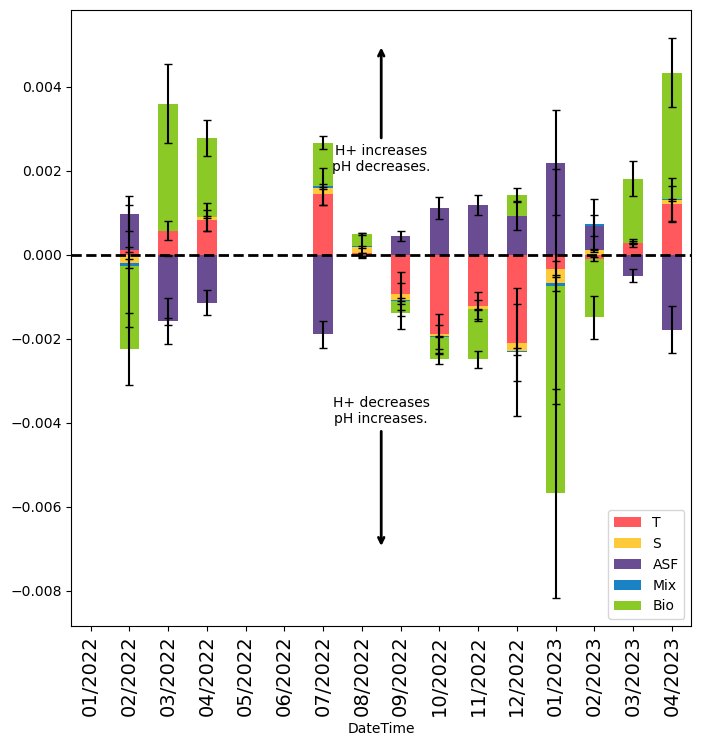

In [21]:
df = comp620
dt = std620
title = 'Hydrocat 620'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])

fig, ax = plt.subplots(figsize = [8,8])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.legend(loc = 'lower right')


plt.annotate('H+ increases\npH decreases.',
             xy=(7.5,0.005),
             xytext=(7.5, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

plt.annotate('H+ decreases\npH increases.',
             xy=(7.5,-0.007),
             xytext=(7.5, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))


Text(0.5, 1.0, 'Hydrocat 620')

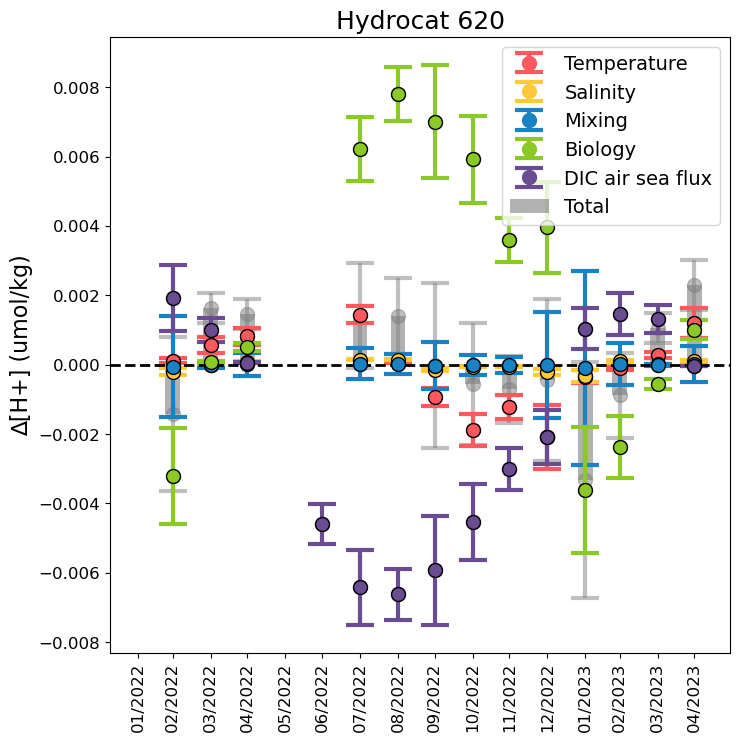

In [56]:
fig, ax = plt.subplots(figsize = [8,8])

df = comp620
dt = std620
title = 'Hydrocat 620'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 100, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 100, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 100, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 100, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 100, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



Text(0.5, 1.0, 'Hydrocat 620')

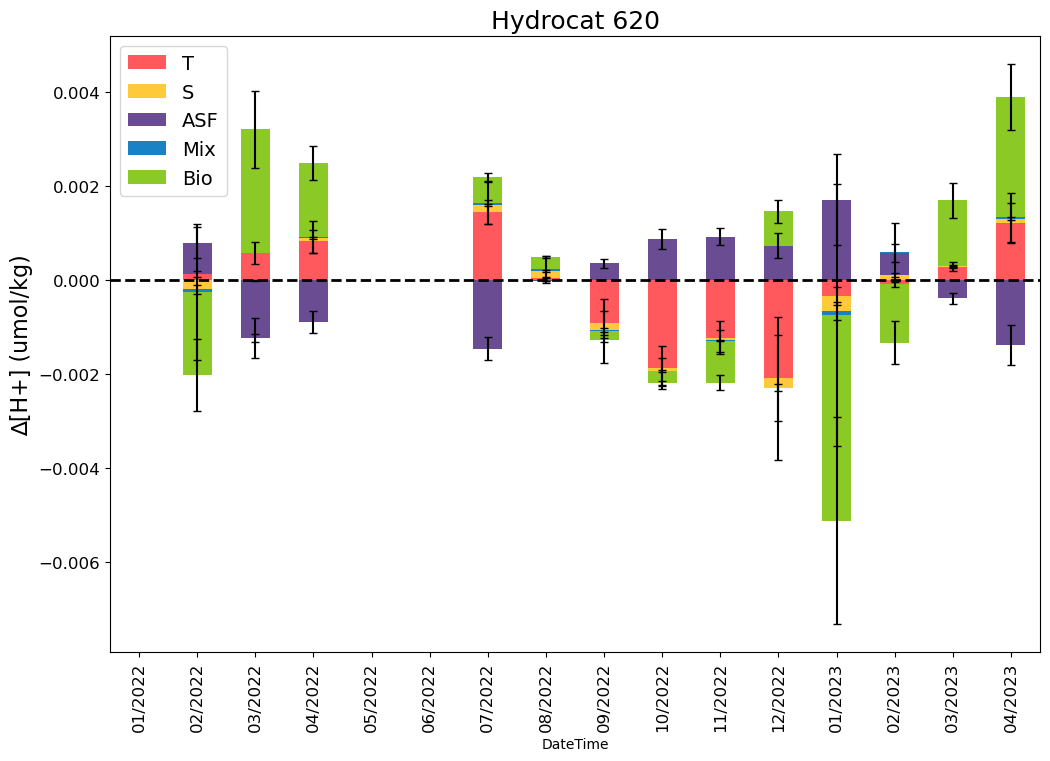

In [744]:
df = comp620
dt = std620
title = 'Hydrocat 620'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])

fig, ax = plt.subplots(figsize = [12,8])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)


ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)





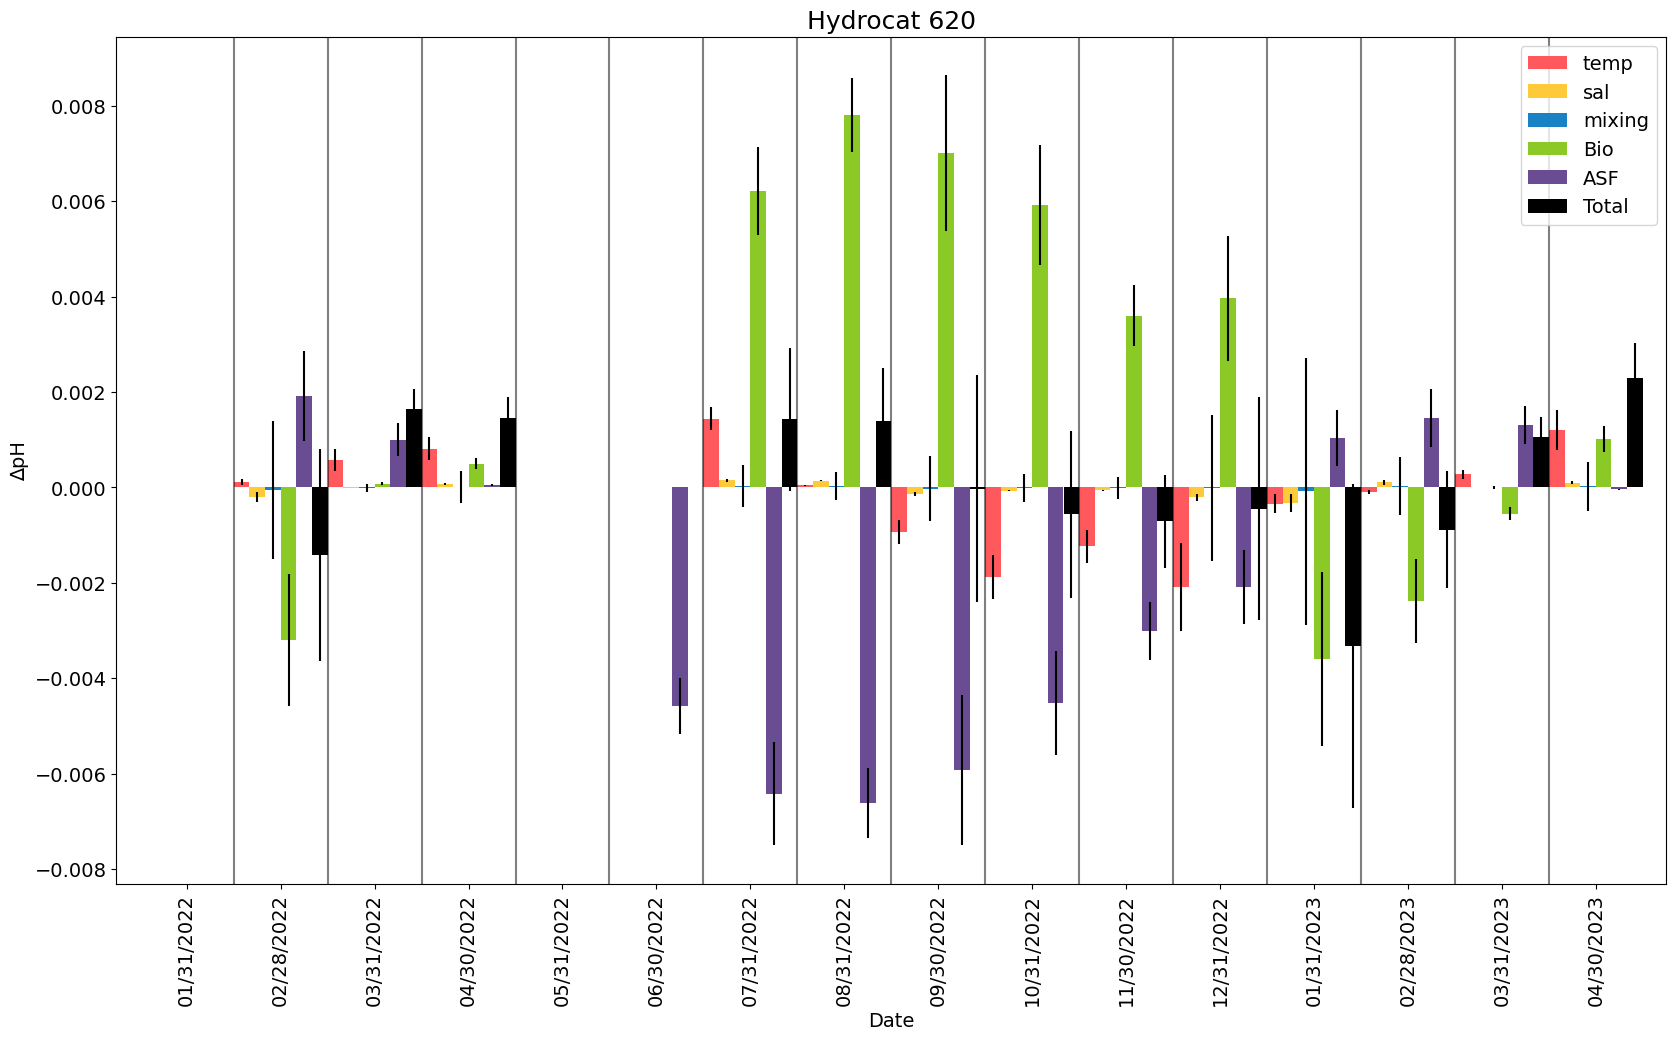

In [57]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [20,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('Hydrocat 620', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[4]+ran[5])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[5]+ran[6])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[6]+ran[7])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[7]+ran[8])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[8]+ran[9])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[9]+ran[10])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[10]+ran[11])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[11]+ran[12])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[12]+ran[13])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[13]+ran[14])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[14]+ran[15])/2, color = 'k', alpha = 0.5)


# Hydrocat 720

In [70]:
comp720['DateTime'].iloc[1] = datetime(2022,2,28)

Text(0.5, 1.0, 'Hydrocat 720')

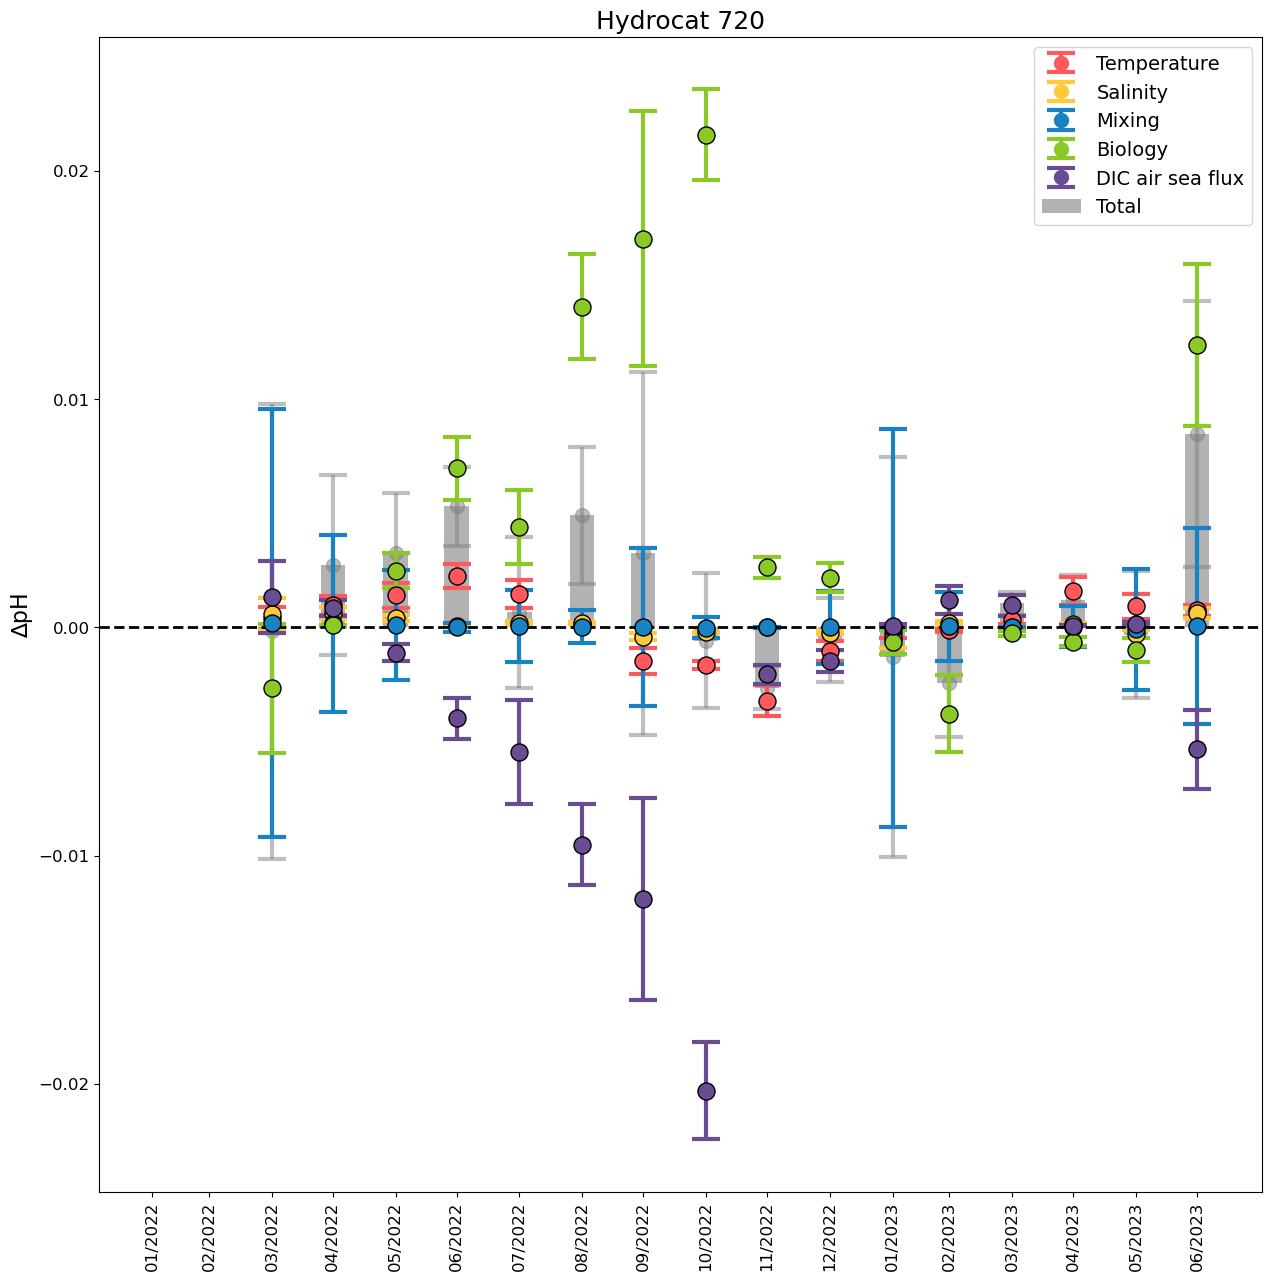

In [71]:
fig, ax = plt.subplots(figsize = [15,15])

df = comp720
dt = std720
title = 'Hydrocat 720'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



Text(0.5, 1.0, 'Hydrocat 720')

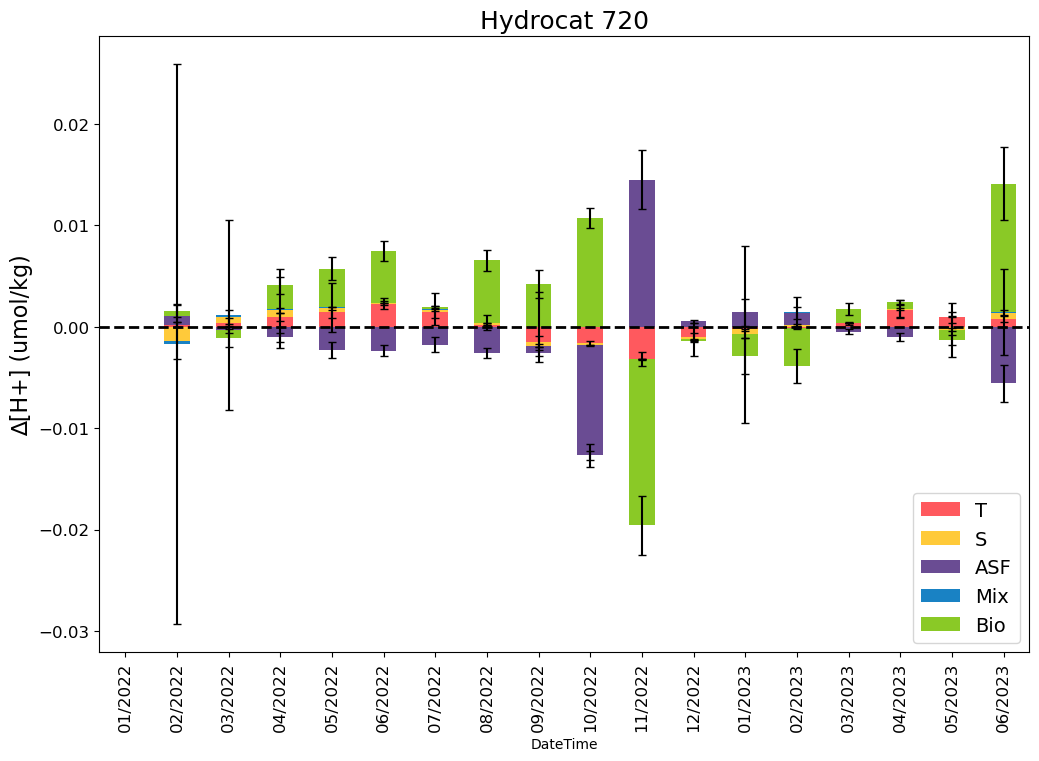

In [571]:
df = comp720
dt = std720
title = 'Hydrocat 720'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])

fig, ax = plt.subplots(figsize = [12,8])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)





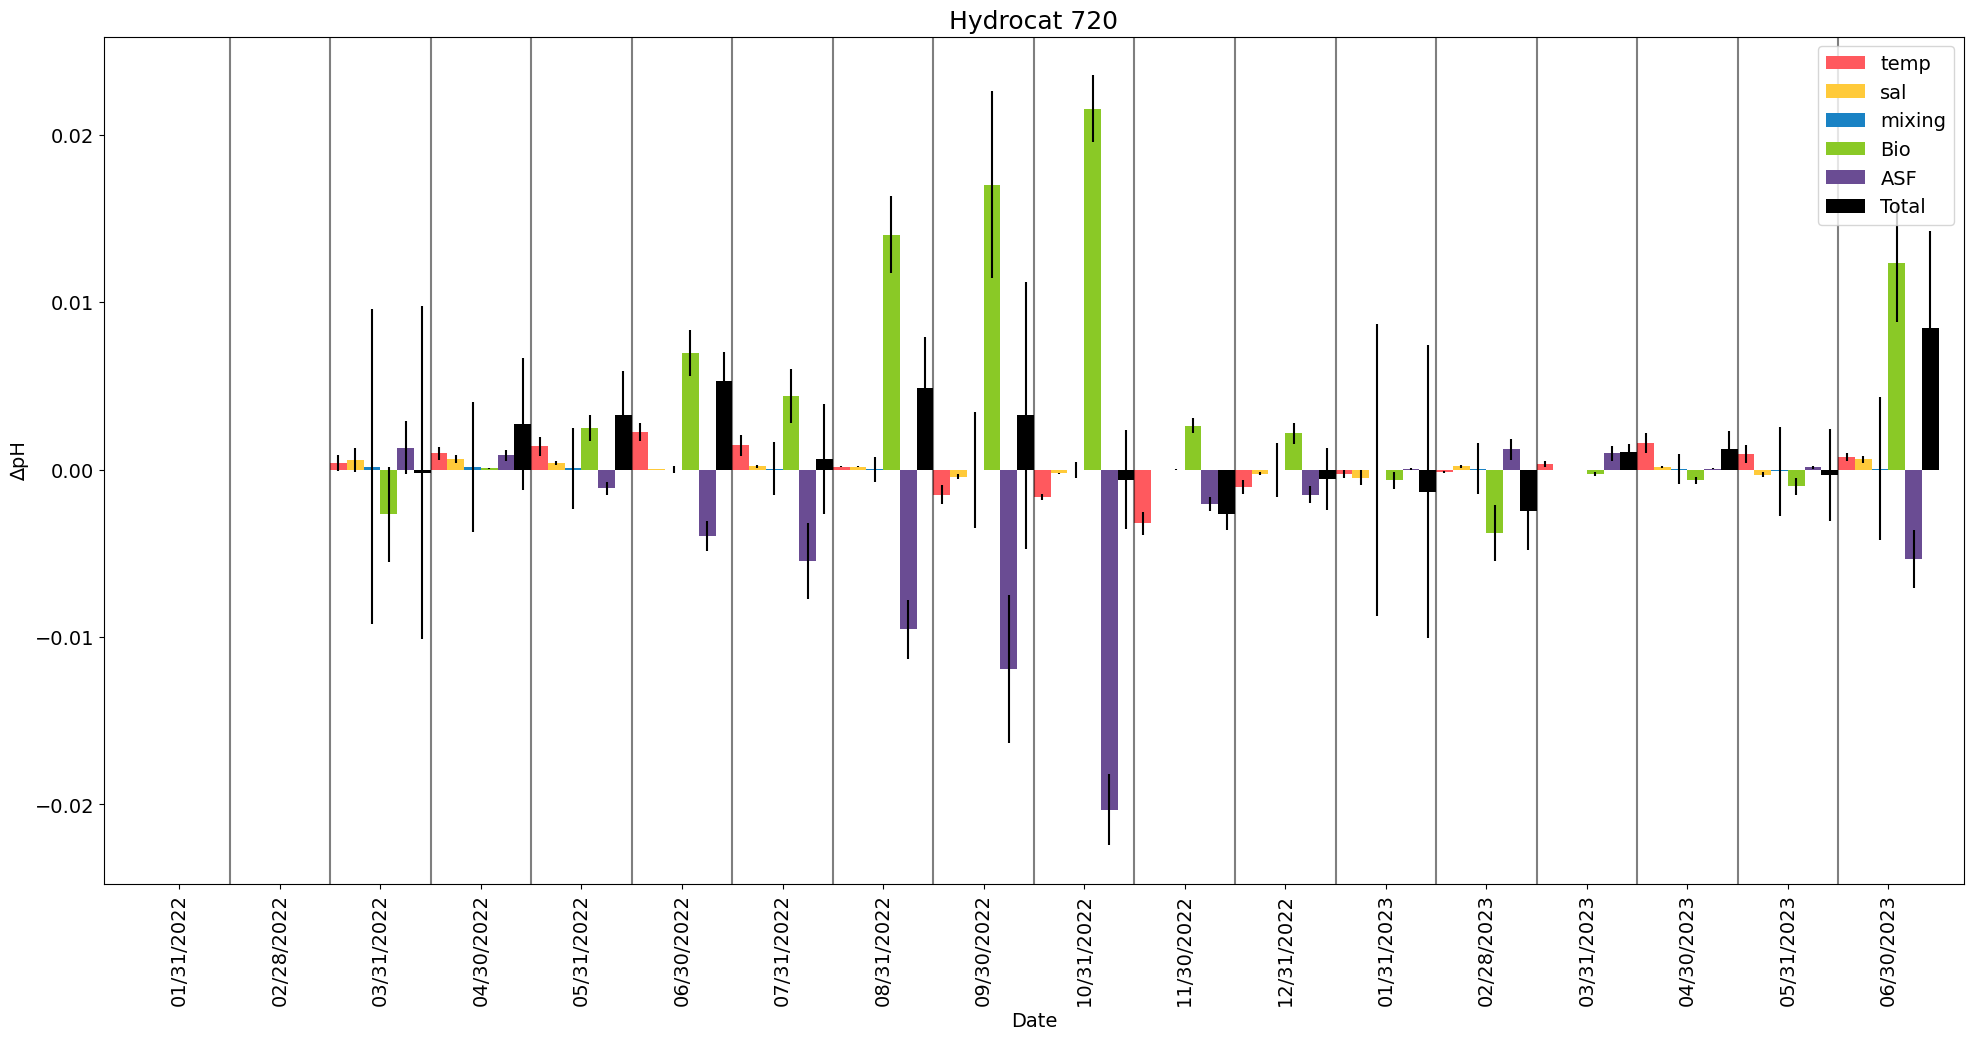

In [72]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [24,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('Hydrocat 720', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[4]+ran[5])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[5]+ran[6])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[6]+ran[7])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[7]+ran[8])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[8]+ran[9])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[9]+ran[10])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[10]+ran[11])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[11]+ran[12])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[12]+ran[13])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[13]+ran[14])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[14]+ran[15])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[15]+ran[16])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[16]+ran[17])/2, color = 'k', alpha = 0.5)



# MV

Text(0.5, 1.0, 'MV')

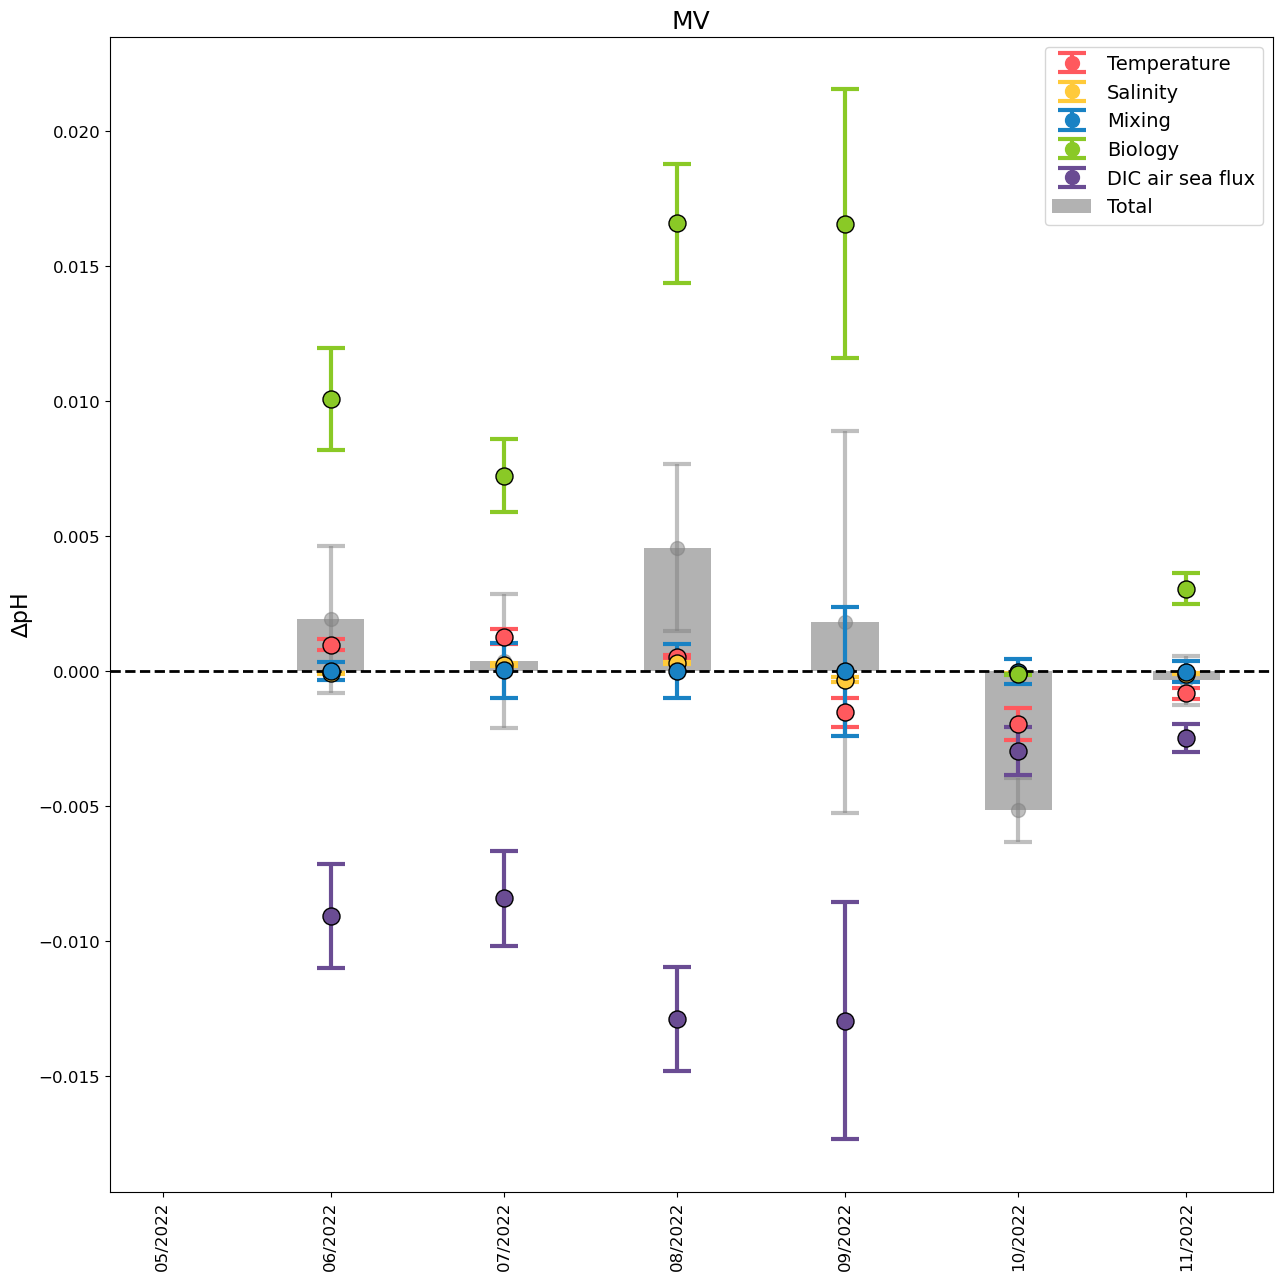

In [75]:
fig, ax = plt.subplots(figsize = [15,15])

df = compMV
dt = stdMV
title = 'MV'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



Text(0.5, 1.0, 'MV')

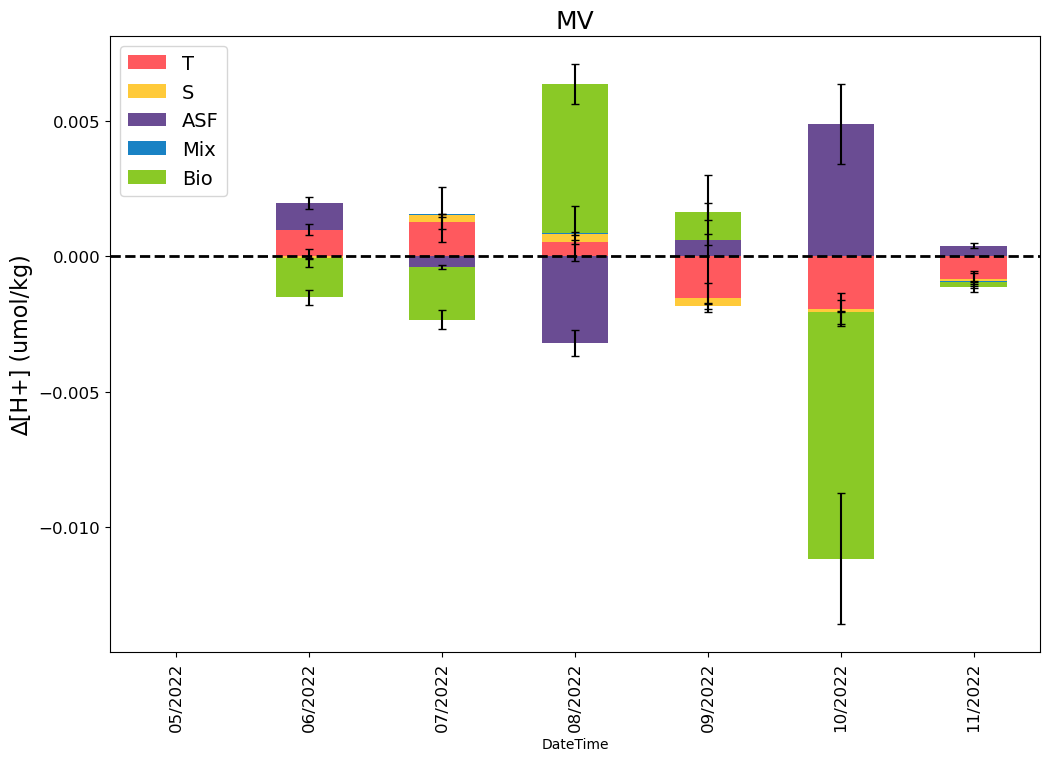

In [574]:
df = compMV
dt = stdMV
title = 'MV'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])

fig, ax = plt.subplots(figsize = [12,8])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)





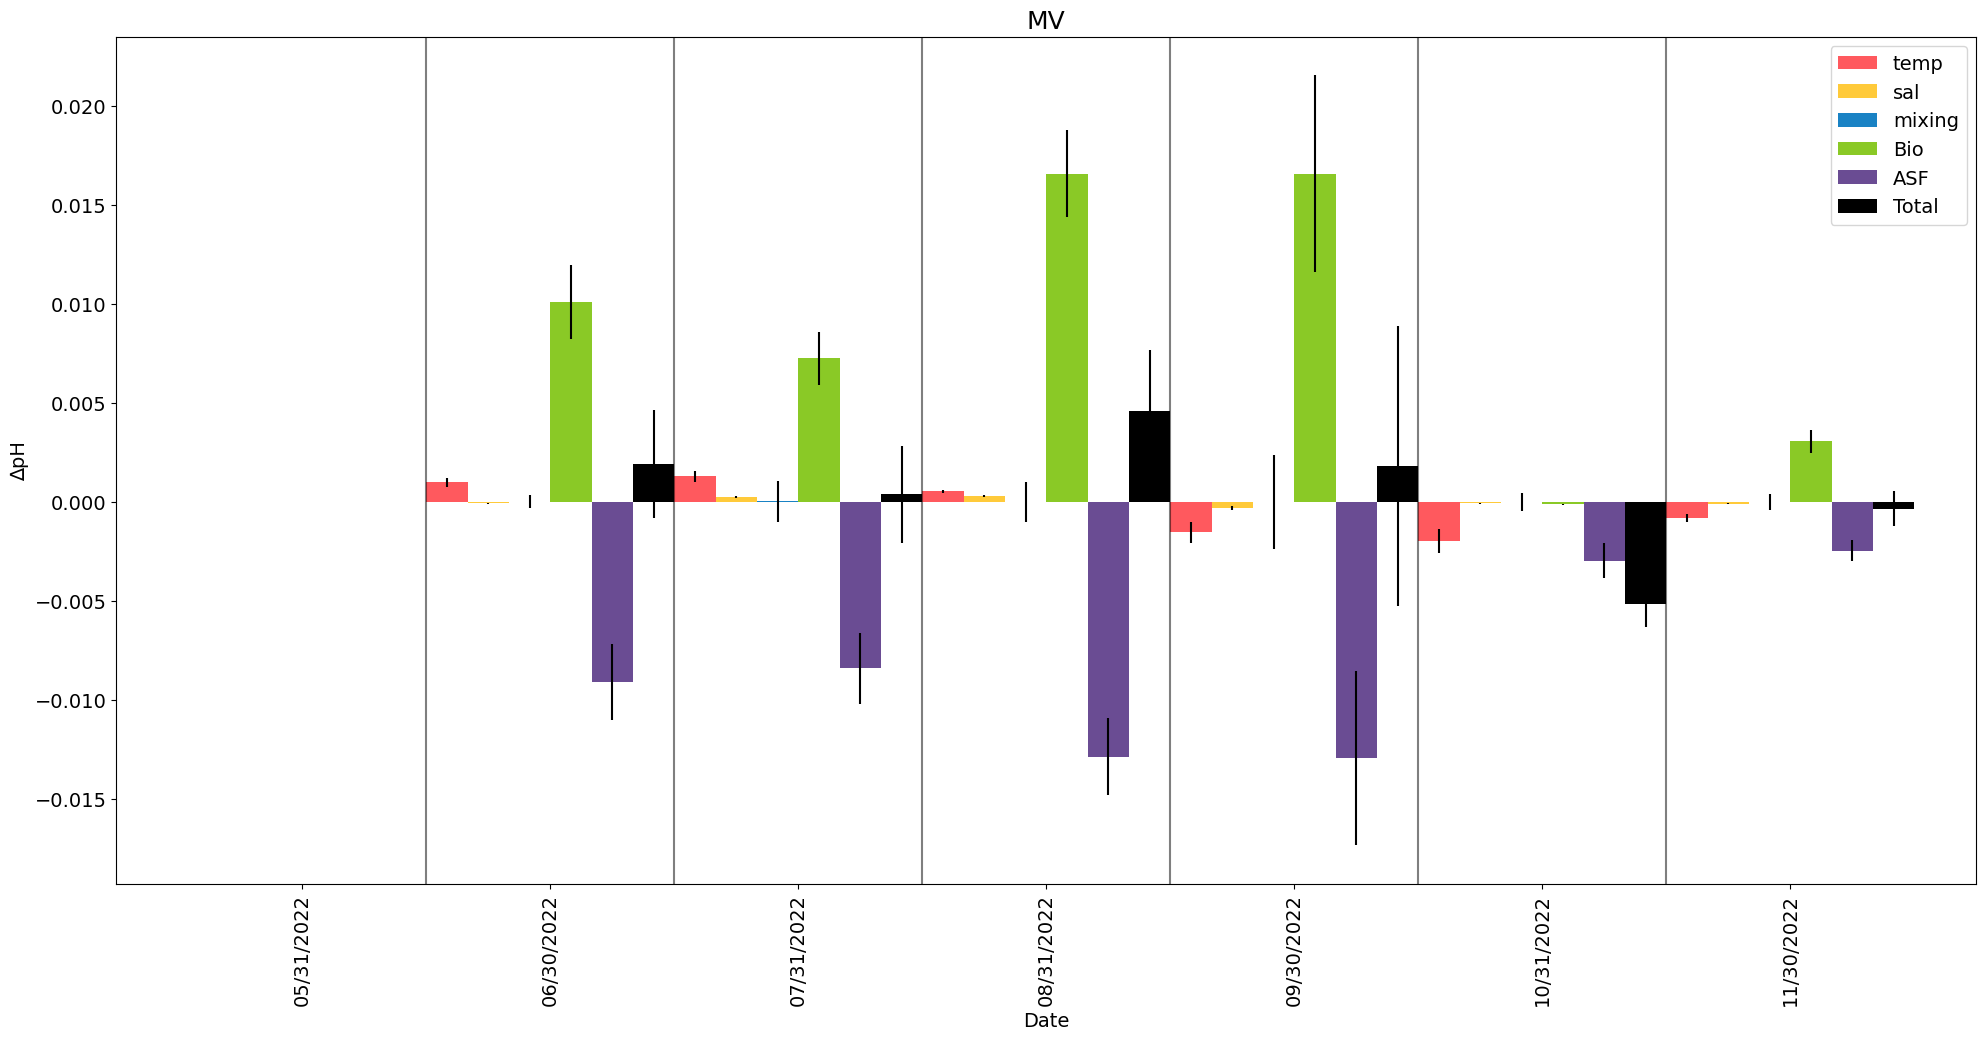

In [76]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [24,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('MV', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[4]+ran[5])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[5]+ran[6])/2, color = 'k', alpha = 0.5)



# QP

Text(0.5, 1.0, 'QP')

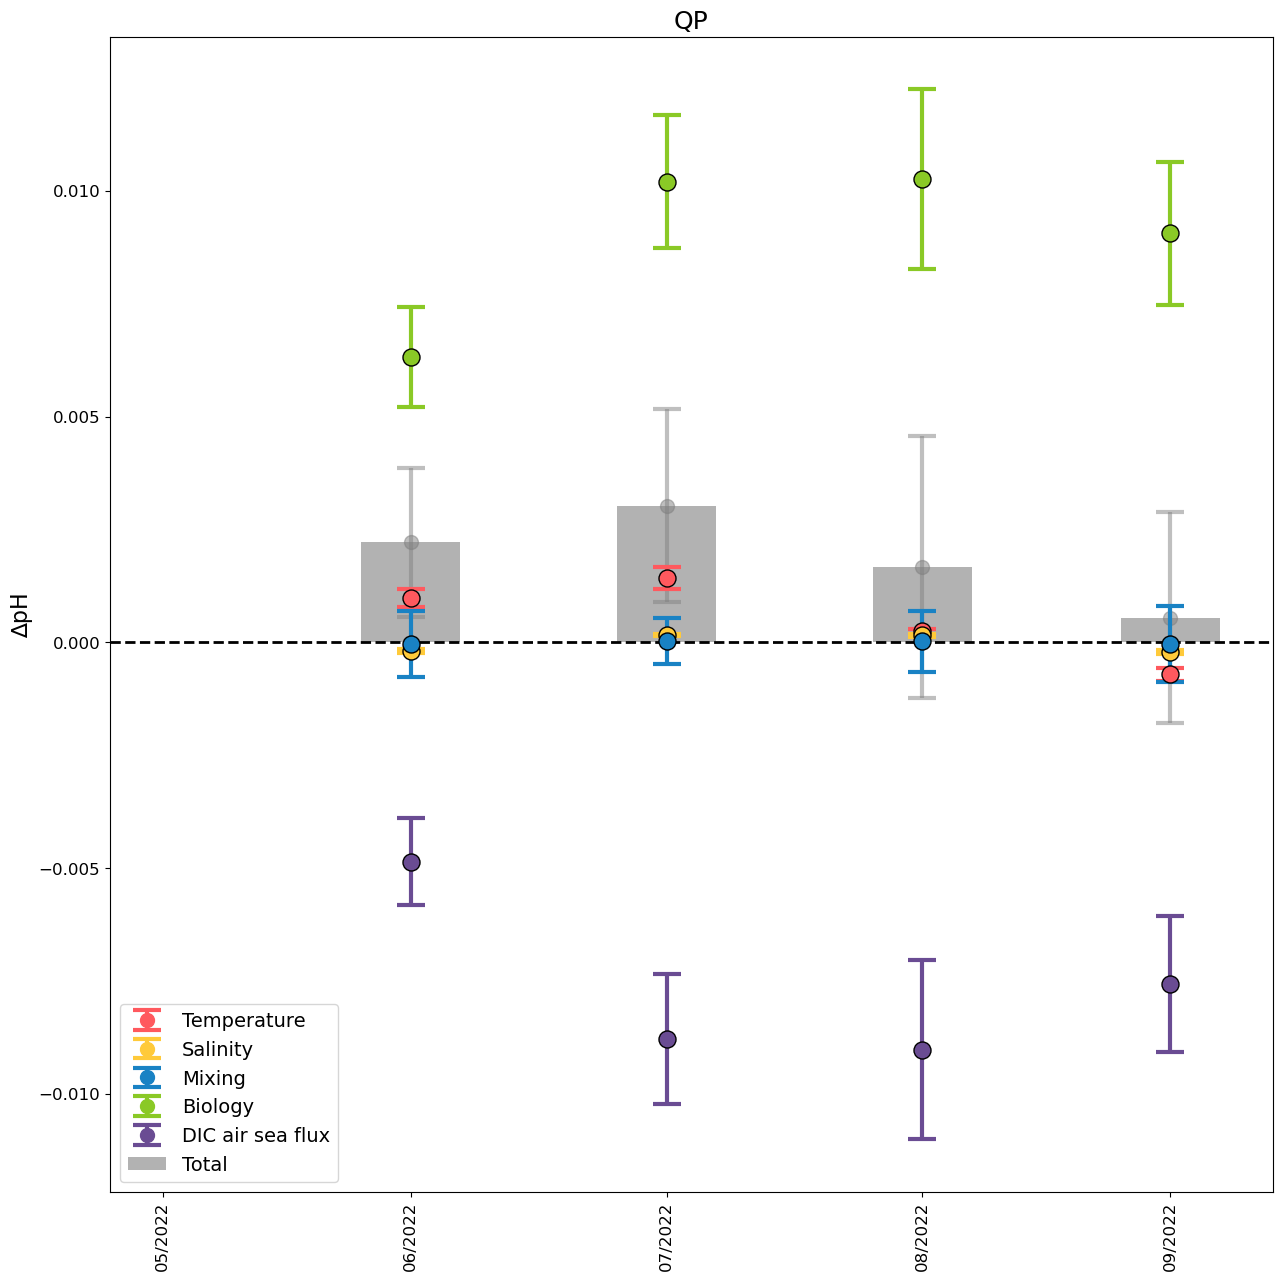

In [77]:
fig, ax = plt.subplots(figsize = [15,15])

df = compQP
dt = stdQP
title = 'QP'

# TEMPERATURE
ax.errorbar(df['DateTime'], df['Temperature'], yerr = dt['Temperature'], label = 'Temperature',
            fmt='o',capsize = 10, color = red, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Temperature'], facecolors = red, edgecolors = 'k', s = 150, zorder = 3)

# SALINITY
ax.errorbar(df['DateTime'], df['Salinity'], yerr = dt['Salinity'], label = 'Salinity',
            fmt='o',capsize = 10, color = yellow, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Salinity'], facecolors = yellow, edgecolors = 'k', s = 150, zorder = 3)

# MIXING
ax.errorbar(df['DateTime'], df['Total mixing'], yerr = dt['Total mixing'], label = 'Mixing',
            fmt='o',capsize = 10, color = blue, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total mixing'], facecolors = blue, edgecolors = 'k', s = 150, zorder = 3)

# BIO
ax.errorbar(df['DateTime'], df['Total bio'], yerr = dt['Total bio'], label = 'Biology',
            fmt='o',capsize = 10, color = green, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['Total bio'], facecolors = green, edgecolors = 'k', s = 150, zorder = 3)

# AIR SEA FLUX
ax.errorbar(df['DateTime'], df['DIC air sea flux'], yerr = dt['DIC ASF'], label = 'DIC air sea flux',
            fmt='o',capsize = 10, color = purple, lw = 3, capthick = 3, markersize = 10)
ax.scatter(df['DateTime'], df['DIC air sea flux'], facecolors = purple, edgecolors = 'k', s = 150, zorder = 3)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df['DateTime'], df['Total'], yerr = dt['Total error'],
            fmt='o',capsize = 10, color = 'gray', lw = 3, capthick = 3, markersize = 10, alpha = 0.5, zorder = 1)
ax.bar(df['DateTime'], df['Total'], color = 'gray', width = 12,label = 'Total', alpha = 0.6, zorder = 1)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆pH', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)



Text(0.5, 1.0, 'QP')

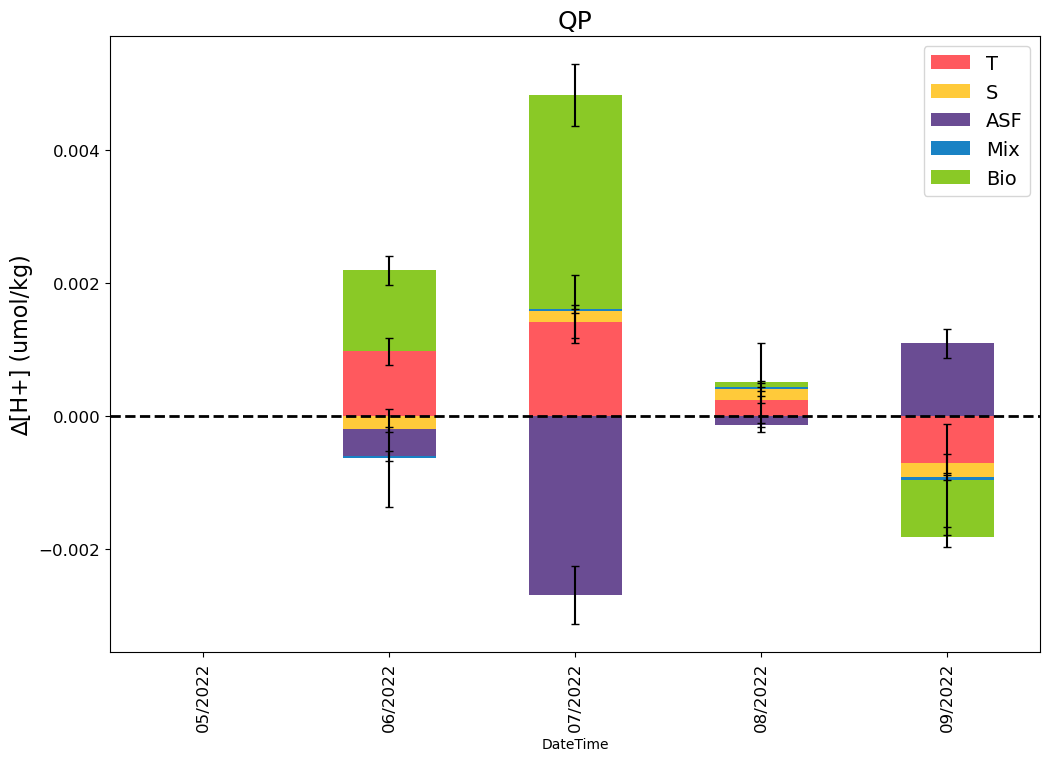

In [577]:
df = compQP
dt = stdQP
title = 'QP'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])

fig, ax = plt.subplots(figsize = [12,8])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 18)





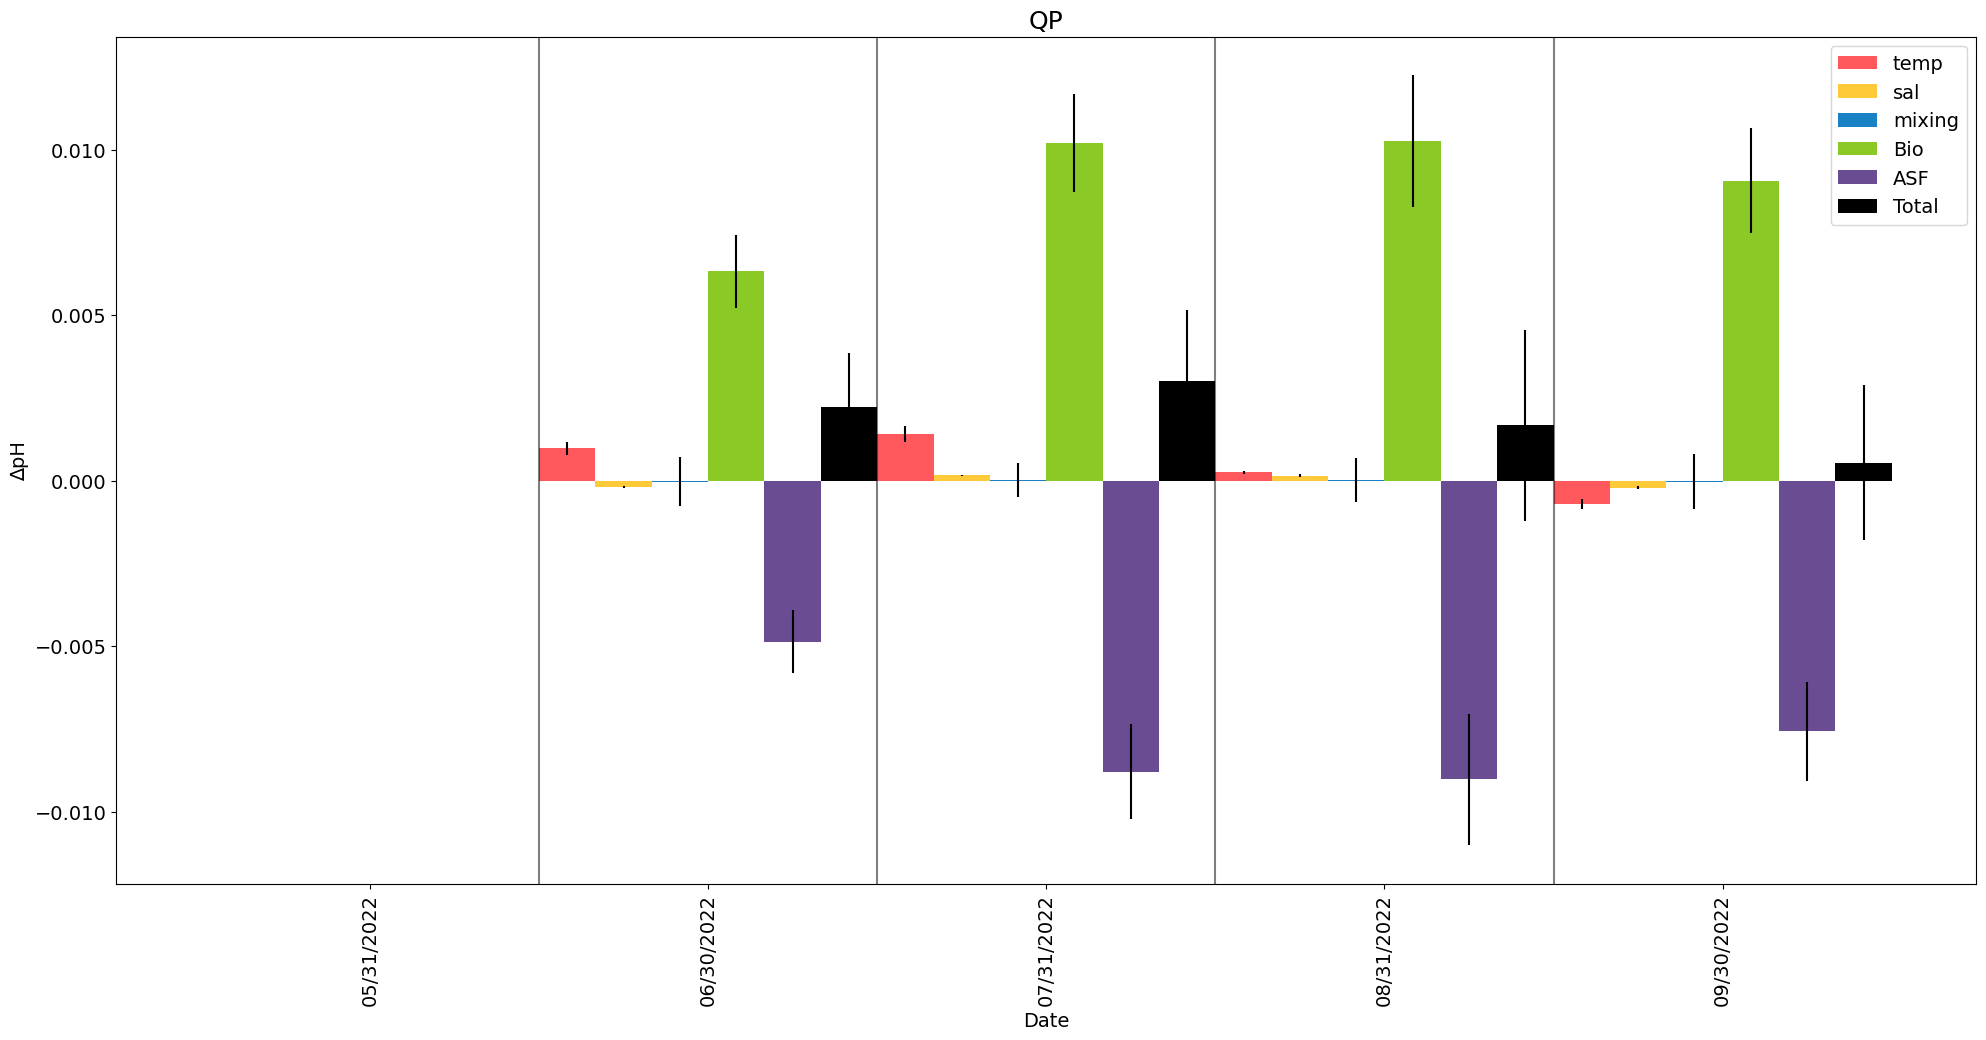

In [78]:
temp = df['Temperature']
sal = df['Salinity']
mix = df['Total mixing']
bio = df['Total bio']
asf = df['DIC air sea flux']
tot = df['Total']
index = df['DateTime']

dT = dt['Temperature']
dS = dt['Salinity']
dM = dt['Total mixing']
dB = dt['Total bio']
dF = dt['DIC ASF']
dTot = dt['Total error']
index = df['DateTime']
DF = pd.DataFrame({'temp': temp,
                   'sal': sal,
                   'mixing': mix,
                   'Bio': bio,
                   'ASF': asf,
                   'Total': tot}, index=index)

fig, ax = plt.subplots(figsize = [24,11])
DF.plot.bar(ax=ax, width = 1, color = [red,yellow,blue,green,purple, 'black'], yerr = [dT,dS,dM,dB,dF,dTot],
           ecolor='black')
ax.set_xticks(np.arange(len(df['DateTime'])))
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_title('QP', fontsize = 18)
ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('y',labelsize = 14)
ax.legend(fontsize = 14)
ran = np.arange(len(df['DateTime']))
ax.axvline((ran[1]+ran[0])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[1]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[2])/2, color = 'k', alpha = 0.5)
ax.axvline((ran[3]+ran[4])/2, color = 'k', alpha = 0.5)



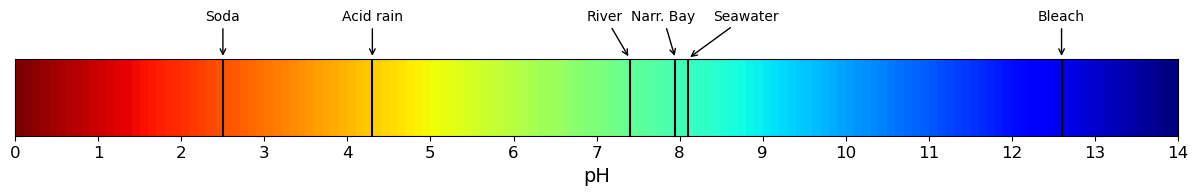

In [323]:
fig, ax = plt.subplots(figsize = [15,1])

# Z = np.arange(1,14.1,0.1)
# x = np.arange(1,14.1,0.1)
# y = np.arange(1,1.1,0.1)

np.random.seed(19680801)
Z = np.random.rand(14,14)
x = np.arange(0, 14.1, 0.1)  # len = 11
y = np.arange(0, 14.1,0.1)  # len = 7
C = np.mgrid[1:15:0.1, 1:15:0.1]
Z = C[0,:,:].transpose()
ax.pcolormesh(y,x,Z, cmap = 'jet_r')
ax.set_yticks([])
ax.tick_params('x',labelsize = 12)
ax.axvline(x = 7.95, color = 'k')
# ax.text(7.95, 15, 'Narragansett \nBay', horizontalalignment="center",
#        fontsize = 12)
plt.annotate('Narr. Bay',xy=(7.95, 14),xytext=(7.8, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 8.1, color = 'k')
plt.annotate('Seawater',xy=(8.1, 14),xytext=(8.8, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 7.4, color = 'k')
plt.annotate('River',xy=(7.4, 14),xytext=(7.1, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 2.5, color = 'k')
plt.annotate('Soda',xy=(2.5, 14),xytext=(2.5, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 12.6, color = 'k')
plt.annotate('Bleach',xy=(12.6, 14),xytext=(12.6, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
ax.axvline(x = 4.3, color = 'k')
plt.annotate('Acid rain',xy=(4.3, 14),xytext=(4.3, 21) ,horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=1))
# ax.text(8.1, 15, 'Ocean \nAvg', horizontalalignment="center",
#        fontsize = 12)

ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]);
# ax.set_xticklabels([10**0,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10,10**-11,10**-12,10**-13,10**-14]);
# ax.set_xlabel('[H+] (mol/L)', fontsize = 12)
ax.set_xlabel('pH', fontsize = 14)
fig.savefig('/Users/akbaskind/Desktop/pHscale.png', bbox_inches='tight', transparent = True)

Text(6, -0.004, 'H+ decreases\npH increases.')

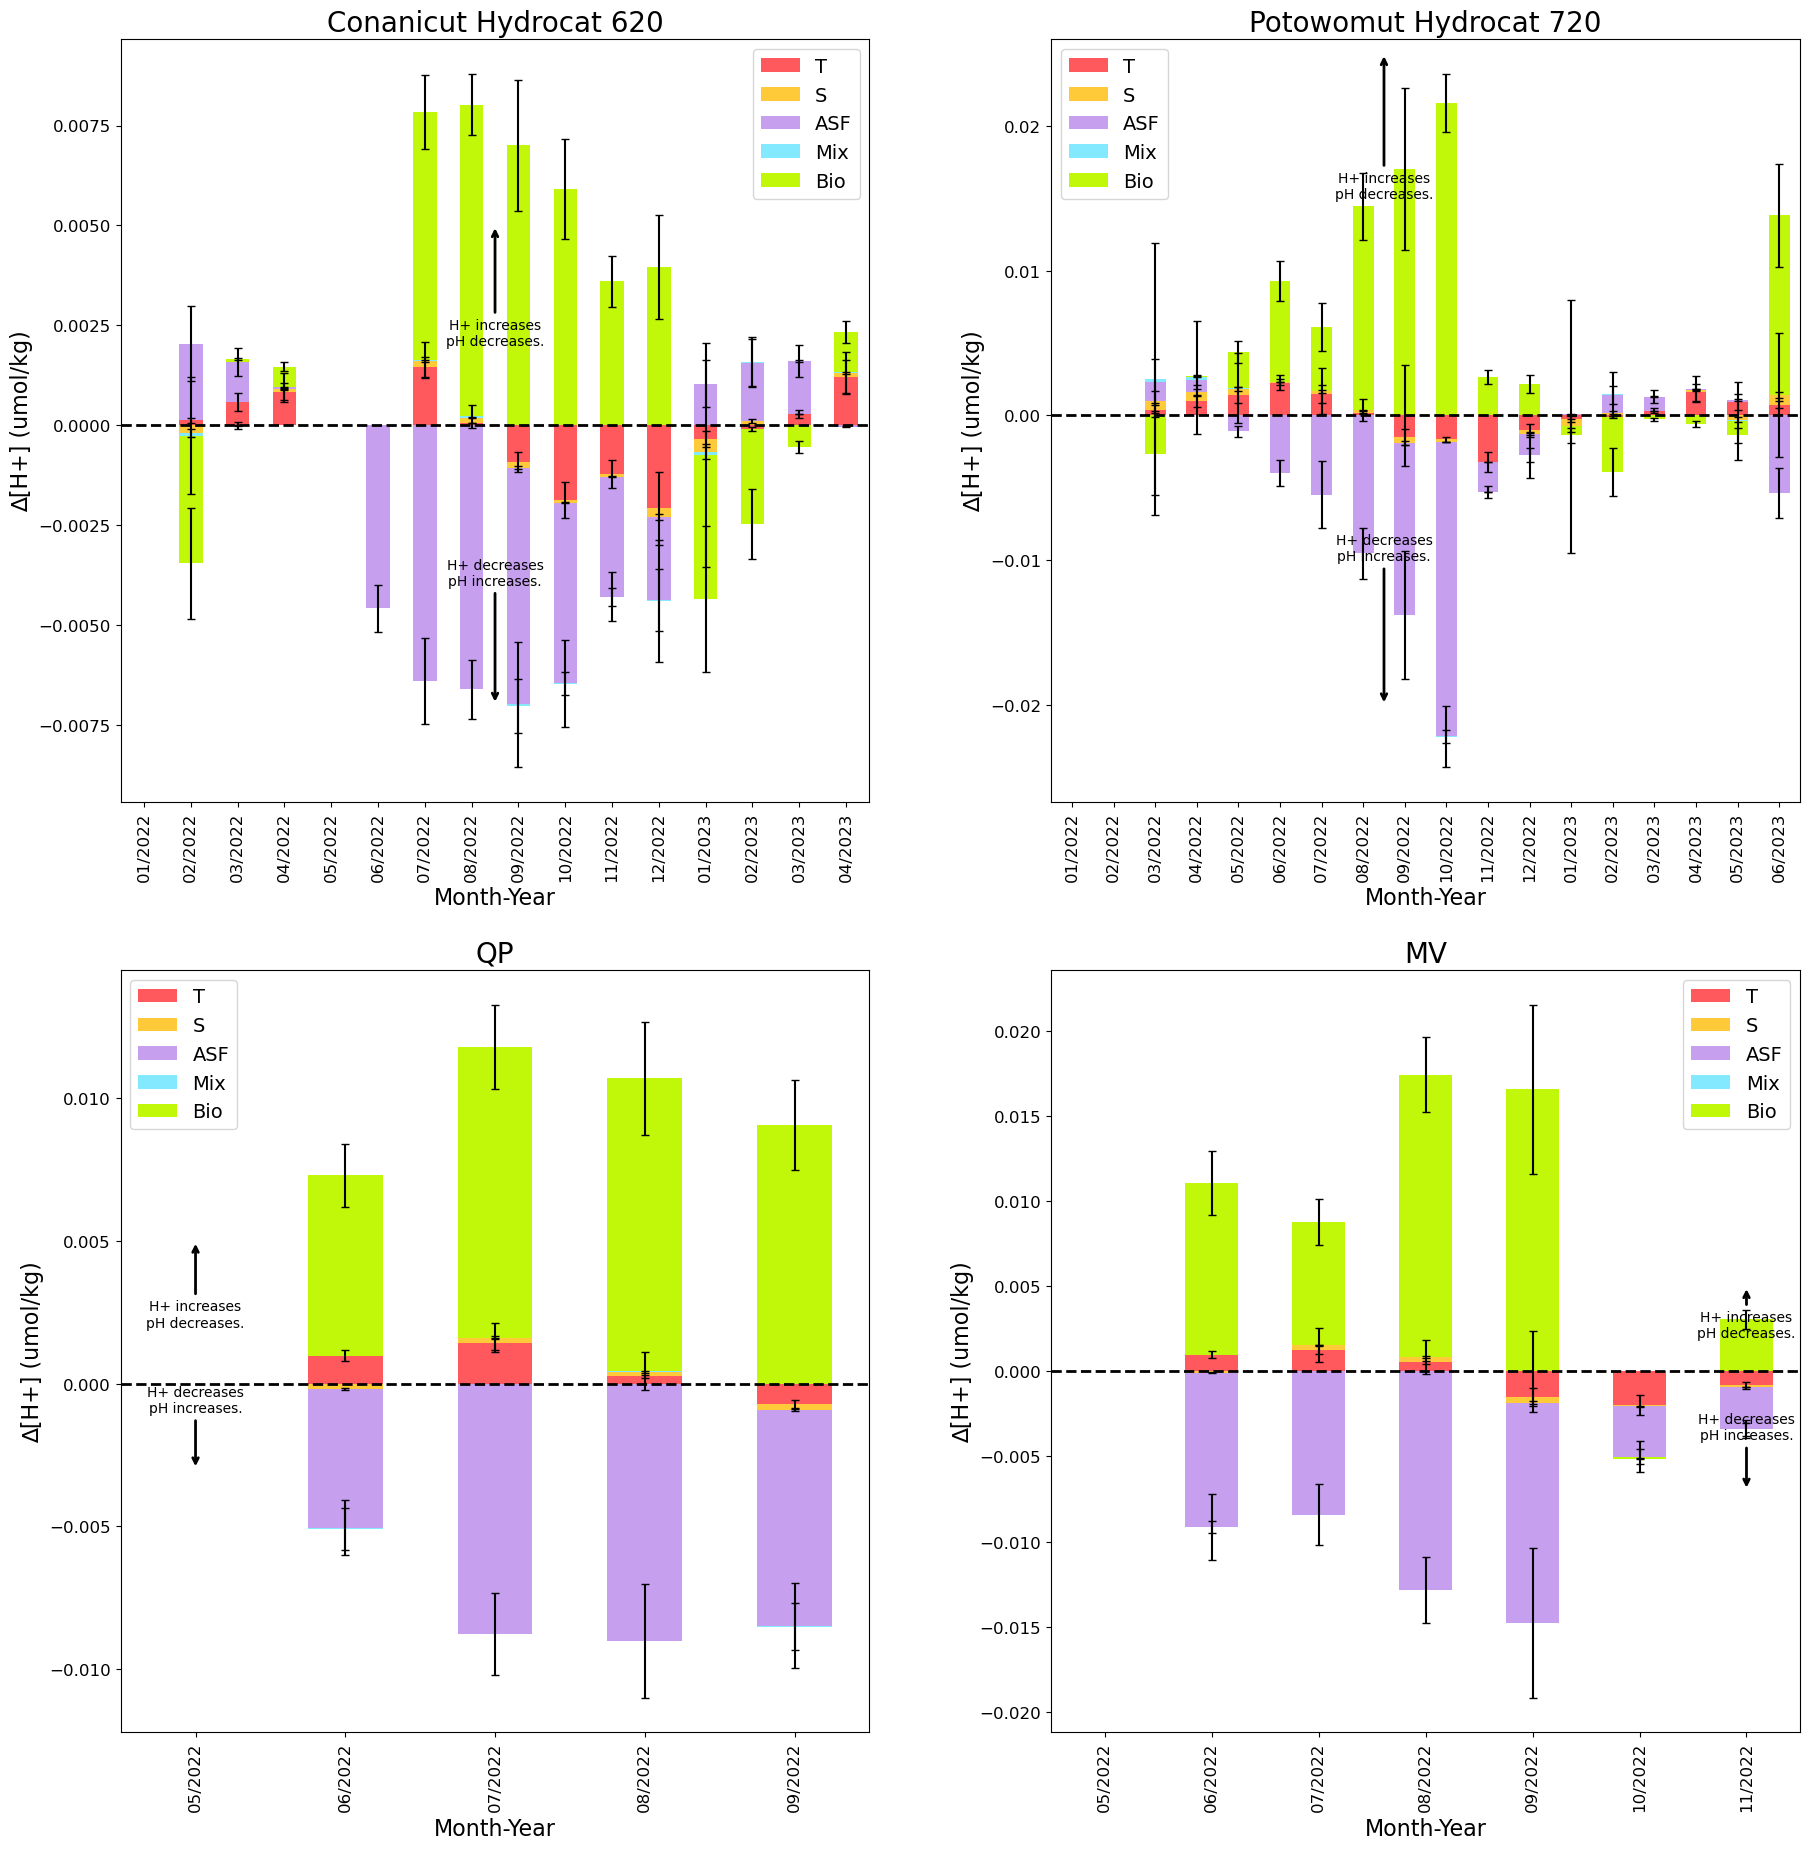

In [22]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
fig.tight_layout(pad=10.0)
axarr = axarr.flatten()

ax = axarr[0]
df = comp620
dt = std620
title = 'Hydrocat 620'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)


ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title('Conanicut Hydrocat 620', fontsize = 20)
ax.annotate('H+ increases\npH decreases.',
             xy=(7.5,0.005),
             xytext=(7.5, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(7.5,-0.007),
             xytext=(7.5, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax = axarr[1]
df = comp720
dt = std720
title = 'Hydrocat 720'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)


ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title('Potowomut Hydrocat 720', fontsize = 20)
ax.annotate('H+ increases\npH decreases.',
             xy=(7.5,0.025),
             xytext=(7.5, 0.015), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(7.5,-0.02),
             xytext=(7.5, -0.01), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax = axarr[2]
df = compQP
dt = stdQP
title = 'QP'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)


ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 20)
ax.annotate('H+ increases\npH decreases.',
             xy=(0,0.005),
             xytext=(0, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(0,-0.003),
             xytext=(0, -0.001), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax = axarr[3]
df = compMV
dt = stdMV
title = 'MV'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)


ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 20)
plt.annotate('H+ increases\npH decreases.',
             xy=(6,0.005),
             xytext=(6, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

plt.annotate('H+ decreases\npH increases.',
             xy=(6,-0.007),
             xytext=(6, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/ALL_components.png', bbox_inches='tight')

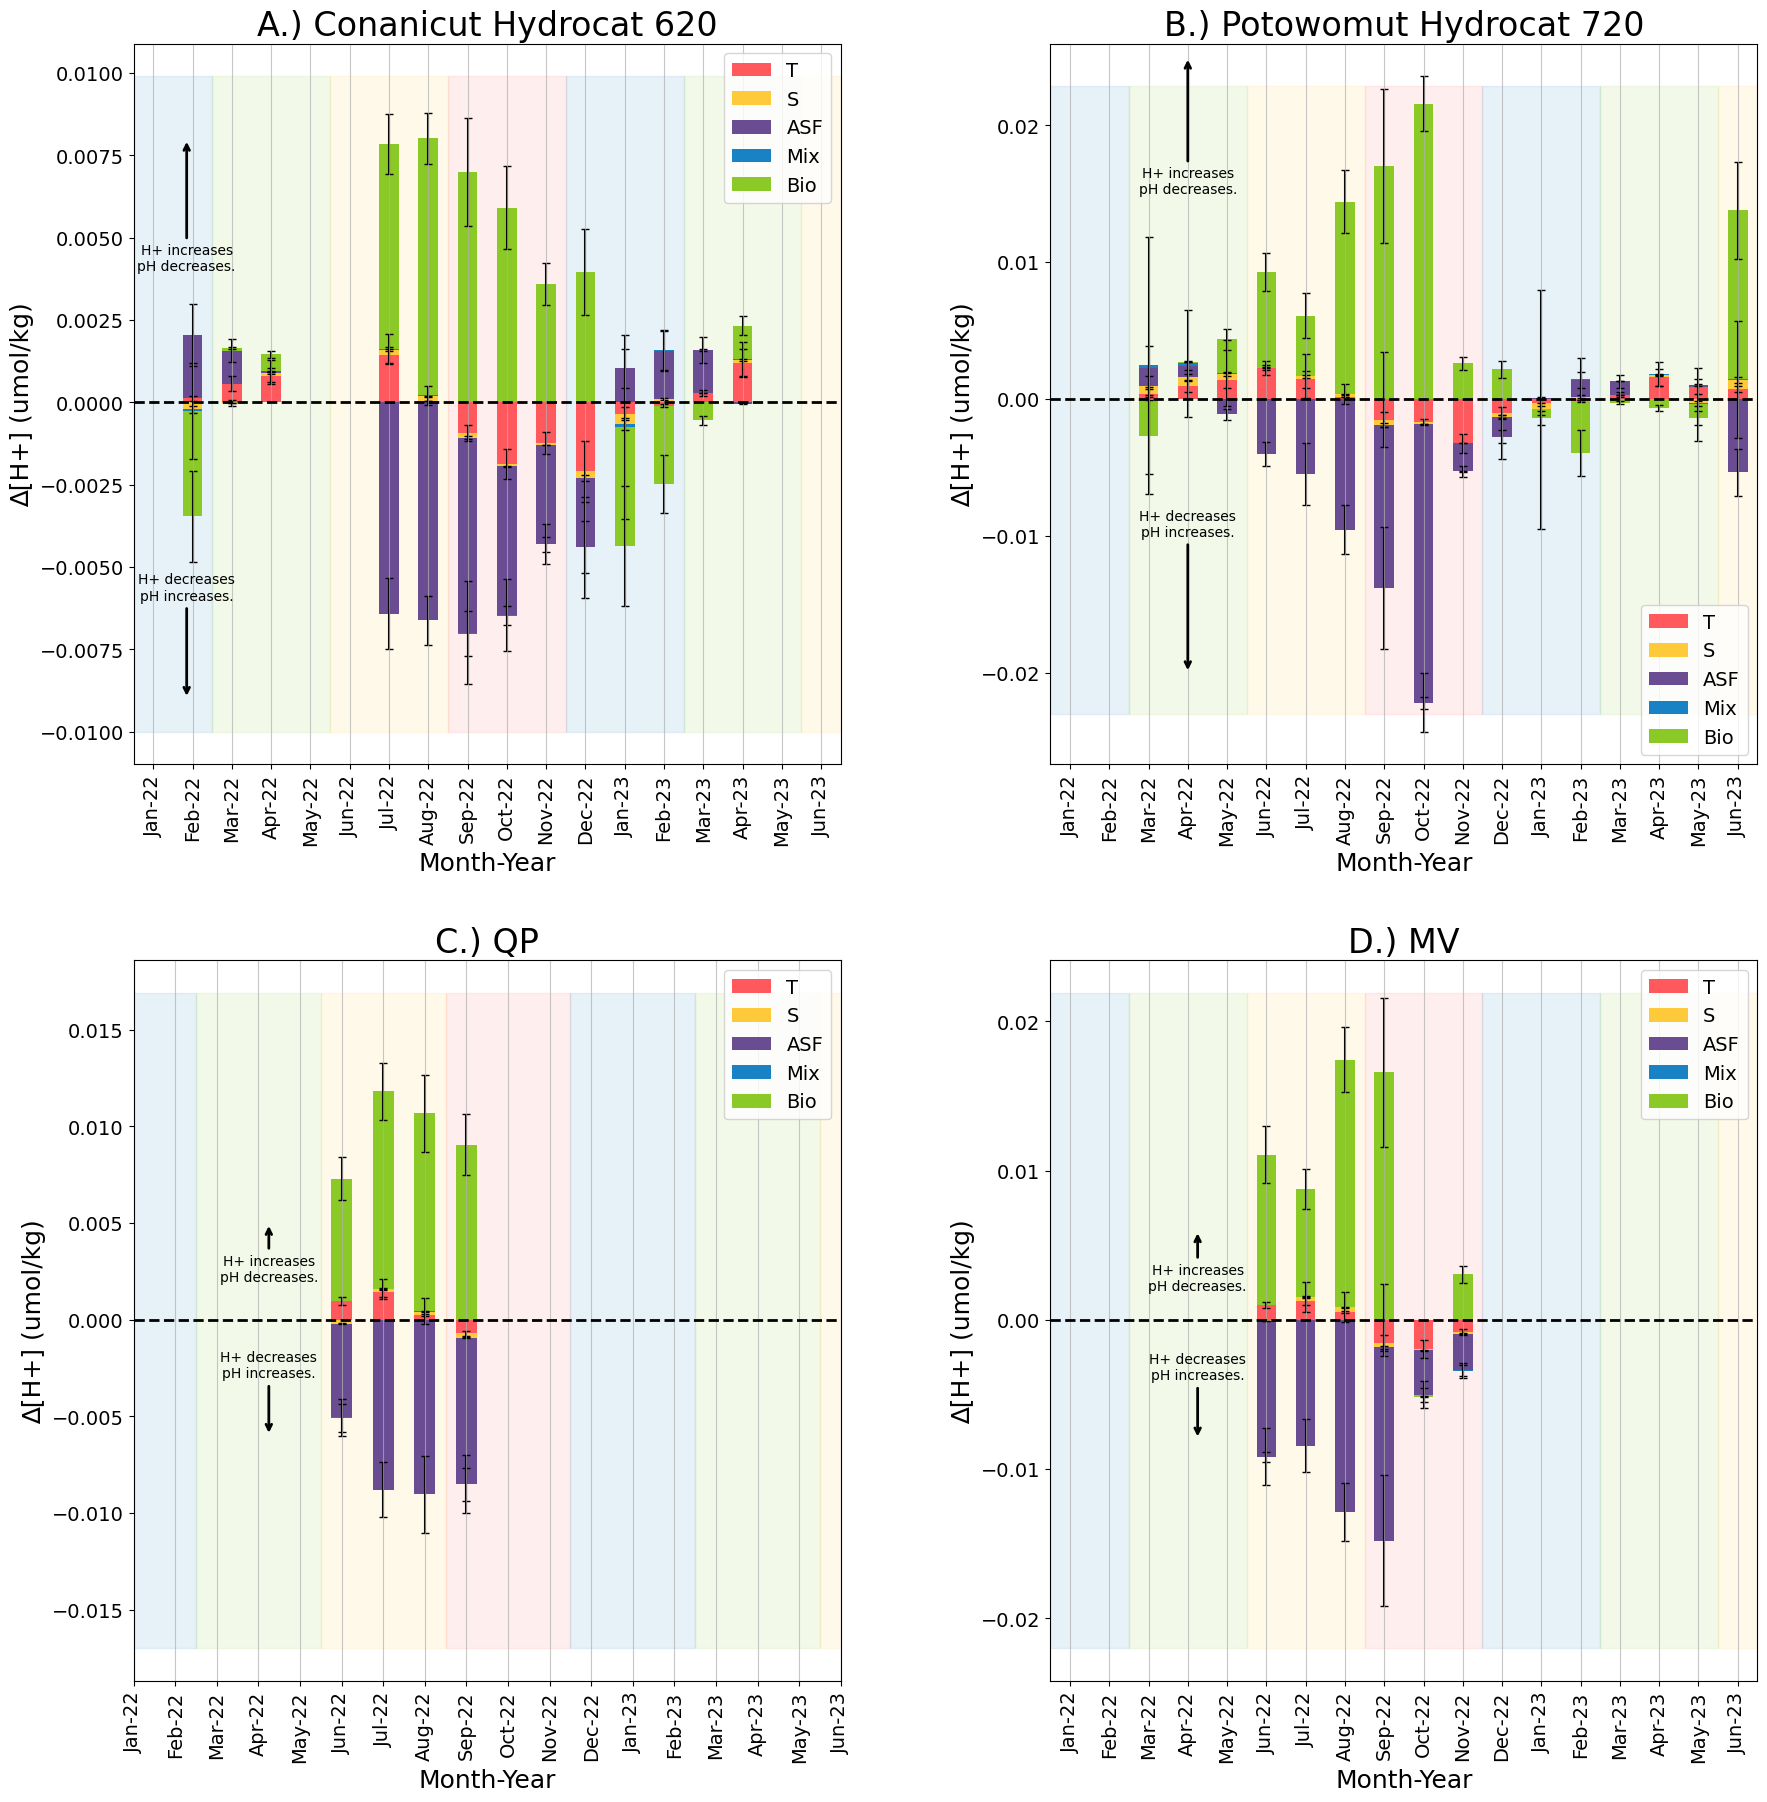

In [124]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
fig.tight_layout(pad=12.0)
axarr = axarr.flatten()
FS = 14

ax = axarr[0]
df = comp620
dt = std620
title = 'A.) Conanicut Hydrocat 620'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 1)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)

ys = np.arange(-0.01,0.01, 0.0001)
ax.fill_betweenx(ys,-4.5+4,-2.5+4, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,-2.5+4,0.5+4, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(ys,0.5+4,3.5+4, alpha = 0.1, color = yellow, zorder = 0)
ax.fill_betweenx(ys,3.5+4,6.5+4, alpha = 0.1, color = red, zorder = 0)
ax.fill_betweenx(ys,6.5+4,9.5+4, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,9.5+4,12.5+4, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(ys,12.5+4,13.5+4, alpha = 0.1, color = yellow, zorder = 0)
ax.set_xticks(xtickslocs)
ax.set_xlim([-0.5,17.5])
ax.set_xticklabels(labs, fontsize = 14);
ax.tick_params('x',labelsize = FS, labelrotation = 90)
ax.tick_params('y',labelsize = FS)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = FS+4)
ax.set_xlabel('Month-Year', fontsize = FS+4)
ax.grid(axis = 'x', which='major', alpha=0.7)  

ax.legend(fontsize = FS)
ax.set_title(title, fontsize = 24)
ax.annotate('H+ increases\npH decreases.',
             xy=(0.85,0.008),
             xytext=(0.85, 0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(0.85,-0.009),
             xytext=(0.85, -0.006), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax = axarr[1]
df = comp720
dt = std720
title = 'B.) Potowomut Hydrocat 720'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 1)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)
ys = np.arange(-0.023,0.023, 0.0001)
ax.fill_betweenx(ys,-4.5+4,-2.5+4, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,-2.5+4,0.5+4, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(ys,0.5+4,3.5+4, alpha = 0.1, color = yellow, zorder = 0)
ax.fill_betweenx(ys,3.5+4,6.5+4, alpha = 0.1, color = red, zorder = 0)
ax.fill_betweenx(ys,6.5+4,9.5+4, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,9.5+4,12.5+4, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(ys,12.5+4,13.5+4, alpha = 0.1, color = yellow, zorder = 0)
xtickslocs = ax.get_xticks()
labs = df.index.strftime('%b-%y')
ax.set_xticklabels(labs, fontsize = 14);
ax.tick_params('x',labelsize = FS, labelrotation = 90)
ax.tick_params('y',labelsize = FS)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = FS+4)
ax.set_xlabel('Month-Year', fontsize = FS+4)
ax.grid(axis = 'x', which='major', alpha=0.7)  

ax.legend(loc = 'lower right', fontsize = FS)
ax.set_title(title, fontsize = 24)
ax.annotate('H+ increases\npH decreases.',
             xy=(3,0.025),
             xytext=(3, 0.015), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(3,-0.02),
             xytext=(3, -0.01), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax = axarr[2]
df = compQP
dt = stdQP
title = 'C.) QP'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 1)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)

ax.set_xticks(xtickslocs-4)
ax.set_xticklabels(labs, fontsize = 14);
ys = np.arange(-0.017,0.017, 0.0001)
ax.fill_betweenx(ys,-4.5,-2.5, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,-2.5,0.5, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(ys,0.5,3.5, alpha = 0.1, color = yellow, zorder = 0)
ax.fill_betweenx(ys,3.5,6.5, alpha = 0.1, color = red, zorder = 0)
ax.fill_betweenx(ys,6.5,9.5, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,9.5,12.5, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(ys,12.5,13.5, alpha = 0.1, color = yellow, zorder = 0)
ax.set_xticklabels(labs, fontsize = 14);
ax.tick_params('x',labelsize = FS, labelrotation = 90)
ax.tick_params('y',labelsize = FS)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = FS+4)
ax.set_xlabel('Month-Year', fontsize = FS+4)
ax.grid(axis = 'x', which='major', alpha=0.7)  

ax.legend(fontsize = FS)
ax.set_title(title, fontsize = 24)
ax.annotate('H+ increases\npH decreases.',
             xy=(-0.75,0.005),
             xytext=(-0.75, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(-0.75,-0.006),
             xytext=(-0.75, -0.003), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax = axarr[3]
df = compMV
dt = stdMV
title = 'D.) MV'

df_ = pd.DataFrame({ 'T': df['Temperature'],
                     'S': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'T': dt['Temperature'],
                     'S': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['T','S','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 1)

# DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)

ax.set_xlim([-4.5,13.5])
ax.set_xticks(xtickslocs-4)
ax.set_xticklabels(labs, fontsize = 14);
ax.set_xticklabels(labs, fontsize = 14);
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),-4.5,-2.5, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),-2.5,0.5, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),0.5,3.5, alpha = 0.1, color = yellow, zorder = 0)
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),3.5,6.5, alpha = 0.1, color = red, zorder = 0)
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),6.5,9.5, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),9.5,12.5, alpha = 0.1, color = green, zorder = 0)
ax.fill_betweenx(np.arange(-0.022,0.022, 0.0001),12.5,13.5, alpha = 0.1, color = yellow, zorder = 0)
ax.tick_params('x',labelsize = FS, labelrotation = 90)
ax.tick_params('y',labelsize = FS)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = FS+4)
ax.set_xlabel('Month-Year', fontsize = FS+4)
ax.grid(axis = 'x', which='major', alpha=0.7)  

ax.legend(fontsize = FS)
ax.set_title(title, fontsize = 24)
plt.annotate('H+ increases\npH decreases.',
             xy=(-0.75,0.006),
             xytext=(-0.75, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

plt.annotate('H+ decreases\npH increases.',
             xy=(-0.75,-0.008),
             xytext=(-0.75, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/ALL_components.png', bbox_inches='tight')

# Average Deco

In [25]:
[a620,b620] = decomposition.ASF(hydrocat620, 'M', location = 'PLT')
[a720,b720] = decomposition.ASF(hydrocat720, 'M', location = 'GB')
[aQP,bQP] = decomposition.ASF(QP, 'M', location = 'PLT')
[aMV,bMV] = decomposition.ASF(MV, 'M', location = 'GB')

A620 = a620.copy()
A620 = A620.drop(columns = 'DateTime')
A620 = A620.reset_index()

AQP = aQP.copy()
AQP = AQP.drop(columns = 'DateTime')
AQP = AQP.reset_index()

A720 = a720.copy()
A720 = A720.drop(columns = 'DateTime')
A720 = A720.reset_index()

AMV = aMV.copy()
AMV = AMV.drop(columns = 'DateTime')
AMV = AMV.reset_index()

df1ASF = pd.concat((AMV, AQP))
df2ASF = pd.concat((A620,A720))
df3ASF = pd.concat((df1ASF,df2ASF))
meanASF = df3ASF.groupby(df3ASF['DateTime']).mean()
meanASF

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC_bio,DIC air sea flux,Total bio,Total mixing,Total
DateTime,,,,,,,,,,
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,27.194409,NaN,NaN,NaN
2022-02-28,0.765013,-4.035791,-208.206454,6.626262,-204.170663,-44.313129,48.356181,-37.686867,-412.377118,-404.978582
2022-03-31,2.142108,1.551348,80.034057,4.862206,78.482709,-32.516001,28.698635,-27.653795,158.516766,163.255062
2022-04-30,3.333074,1.505663,77.677137,-0.640629,76.171474,4.284207,8.794834,3.643578,153.848611,171.125760
2022-05-31,4.560382,1.417011,73.103575,-4.664210,71.686564,31.191903,-46.452482,26.527693,144.790139,161.417215
2022-06-30,3.724124,-0.197118,-10.169311,-9.296510,-9.972194,62.170411,-52.691855,52.873901,-20.141505,-17.321251
2022-07-31,3.910040,0.500623,25.827118,-9.051586,25.326496,60.532480,-71.854048,51.480894,51.153614,35.191122
2022-08-31,0.625676,0.497683,25.675457,-13.953622,25.177775,93.314845,-84.054824,79.361223,50.853232,47.282990
2022-09-30,-2.849724,-0.655570,-33.820870,-13.325942,-33.165299,89.117236,-79.645067,75.791294,-66.986169,-74.345236


In [26]:
A620 = b620.copy()
A620 = A620.drop(columns = 'DateTime')
A620 = A620.reset_index()

AQP = bQP.copy()
AQP = AQP.drop(columns = 'DateTime')
AQP = AQP.reset_index()

A720 = b720.copy()
A720 = A720.drop(columns = 'DateTime')
A720 = A720.reset_index()

AMV = bMV.copy()
AMV = AMV.drop(columns = 'DateTime')
AMV = AMV.reset_index()

for i in AMV.index:
    for key in AMV.keys():
        if key != 'DateTime':
            AMV[key][i] = AMV[key][i]**2
for i in AQP.index:
    for key in AQP.keys():
        if key != 'DateTime':
            AQP[key][i] = AQP[key][i]**2
for i in A620.index:
    for key in A620.keys():
        if key != 'DateTime':
            A620[key][i] = A620[key][i]**2
for i in A720.index:
    for key in A720.keys():
        if key != 'DateTime':
            A720[key][i] = A720[key][i]**2

df1asf = pd.concat((AMV, AQP))
df2asf = pd.concat((A620,A720))
df3asf = pd.concat((df1asf,df2asf))
asfstd = df3asf.groupby(df3asf['DateTime']).sum()

for i in asfstd.index:
    for key in asfstd.keys():
        if key != 'DateTime':
            asfstd[key][i] = np.sqrt(asfstd[key][i])
asfstd

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,
2022-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931522,0.000000,0.000000,0.000000
2022-02-28,0.222420,1.009465,36.752057,0.448640,37.385846,3.394366,5.306423,3.423886,52.425330,52.814438
2022-03-31,0.620383,0.440279,16.642981,1.011030,17.076609,7.074553,4.048052,7.146432,23.845323,25.231654
2022-04-30,0.711131,0.096543,3.747070,0.020142,4.450043,0.145979,0.541048,0.147362,5.817509,5.888369
2022-05-31,0.946822,0.040008,1.571514,0.100267,1.901093,0.827194,1.066391,0.833249,2.466539,2.802409
2022-06-30,0.400590,0.009246,0.365917,0.188074,0.434154,1.609596,1.472629,1.620547,0.567789,2.247568
2022-07-31,0.395939,0.023102,0.913059,0.222241,1.122888,2.067337,2.630629,2.079248,1.447257,3.673600
2022-08-31,0.054205,0.008455,0.336694,0.186808,0.628033,2.386227,2.152258,2.393528,0.712593,3.297270
2022-09-30,0.450725,0.029512,1.165160,0.438833,1.544357,3.973668,3.452219,3.997826,1.934590,5.643323


In [28]:
COMPMV = compMV.copy()
COMPMV = COMPMV.drop(columns = 'DateTime')
COMPMV = COMPMV.reset_index()

COMPQP = compQP.copy()
COMPQP = COMPQP.drop(columns = 'DateTime')
COMPQP = COMPQP.reset_index()

COMP620 = comp620.copy()
COMP620 = COMP620.drop(columns = 'DateTime')
COMP620 = COMP620.reset_index()

COMP720 = comp720.copy()
COMP720 = COMP720.drop(columns = 'DateTime')
COMP720 = COMP720.reset_index()

In [29]:
# df = pd.merge_asof(COMPMV, COMPQP, on="DateTime",tolerance = pd.Timedelta("10m"))
df1 = pd.concat((COMPMV, COMPQP))
df2 = pd.concat((COMP620,COMP720))
df3 = pd.concat((df1,df2))
meancomp = df3.groupby(df3['DateTime']).mean()
meancomp

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC_bio,DIC air sea flux,Total bio,Total mixing,Total
DateTime,,,,,,,,,,
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-28,0.000118,-0.000207,0.002072,-0.000400,-0.002128,-0.002800,0.001920,-0.003199,-5.635331e-05,-0.001424
2022-03-31,0.000484,0.000282,-0.002637,-0.000160,0.002731,-0.001131,0.001164,-0.001292,9.410337e-05,0.000733
2022-04-30,0.000894,0.000355,-0.003866,0.000037,0.003960,0.000254,0.000453,0.000291,9.383379e-05,0.002086
2022-05-31,0.001400,0.000408,-0.004901,0.000313,0.004992,0.002172,-0.001106,0.002485,9.150500e-05,0.003279
2022-06-30,0.001409,-0.000073,0.001025,0.000991,-0.001034,0.006808,-0.005975,0.007799,-8.812320e-06,0.003151
2022-07-31,0.001402,0.000188,-0.002530,0.000887,0.002563,0.006130,-0.007270,0.007017,3.328981e-05,0.001370
2022-08-31,0.000249,0.000201,-0.002874,0.001545,0.002897,0.010629,-0.009510,0.012175,2.348564e-05,0.003137
2022-09-30,-0.001160,-0.000267,0.004074,0.001583,-0.004089,0.010838,-0.009585,0.012421,-1.413664e-05,0.001394


In [30]:
STDMV = stdMV.copy()
STDMV = STDMV.drop(columns = 'DateTime')
STDMV = STDMV.reset_index()

STDQP = stdQP.copy()
STDQP = STDQP.drop(columns = 'DateTime')
STDQP = STDQP.reset_index()

STD620 = std620.copy()
STD620 = STD620.drop(columns = 'DateTime')
STD620 = STD620.reset_index()

STD720 = std720.copy()
STD720 = STD720.drop(columns = 'DateTime')
STD720 = STD720.reset_index()

In [31]:
for i in STDMV.index:
    for key in STDMV.keys():
        if key != 'DateTime':
            STDMV[key][i] = STDMV[key][i]**2
for i in STDQP.index:
    for key in STDQP.keys():
        if key != 'DateTime':
            STDQP[key][i] = STDQP[key][i]**2
for i in STD620.index:
    for key in STD620.keys():
        if key != 'DateTime':
            STD620[key][i] = STD620[key][i]**2
for i in STD720.index:
    for key in STD720.keys():
        if key != 'DateTime':
            STD720[key][i] = STD720[key][i]**2

In [32]:
df1 = pd.concat((STDMV, STDQP))
df2 = pd.concat((STD620,STD720))
df3 = pd.concat((df1,df2))
meanstd = df3.groupby(df3['DateTime']).sum()

for i in meanstd.index:
    for key in meanstd.keys():
        if key != 'DateTime':
            meanstd[key][i] = np.sqrt(meanstd[key][i])
meanstd

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,
2022-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-02-28,0.000064,0.000101,0.001014,0.000196,0.001043,0.001372,0.000941,0.001385,0.001454,0.002221
2022-03-31,0.000532,0.000695,0.006518,0.000396,0.006749,0.002796,0.001625,0.002824,0.009383,0.009971
2022-04-30,0.000479,0.000253,0.002729,0.000017,0.002800,0.000117,0.000340,0.000118,0.003910,0.003964
2022-05-31,0.000564,0.000141,0.001694,0.000108,0.001727,0.000752,0.000383,0.000759,0.002419,0.002629
2022-06-30,0.000598,0.000043,0.000585,0.000372,0.000592,0.002555,0.002327,0.002582,0.000832,0.003624
2022-07-31,0.000760,0.000107,0.001405,0.000392,0.001427,0.002712,0.003412,0.002740,0.002003,0.004873
2022-08-31,0.000104,0.000070,0.001018,0.000551,0.001027,0.003794,0.003371,0.003833,0.001446,0.005307
2022-09-30,0.000829,0.000193,0.003063,0.001133,0.003067,0.007739,0.006613,0.007822,0.004335,0.011155


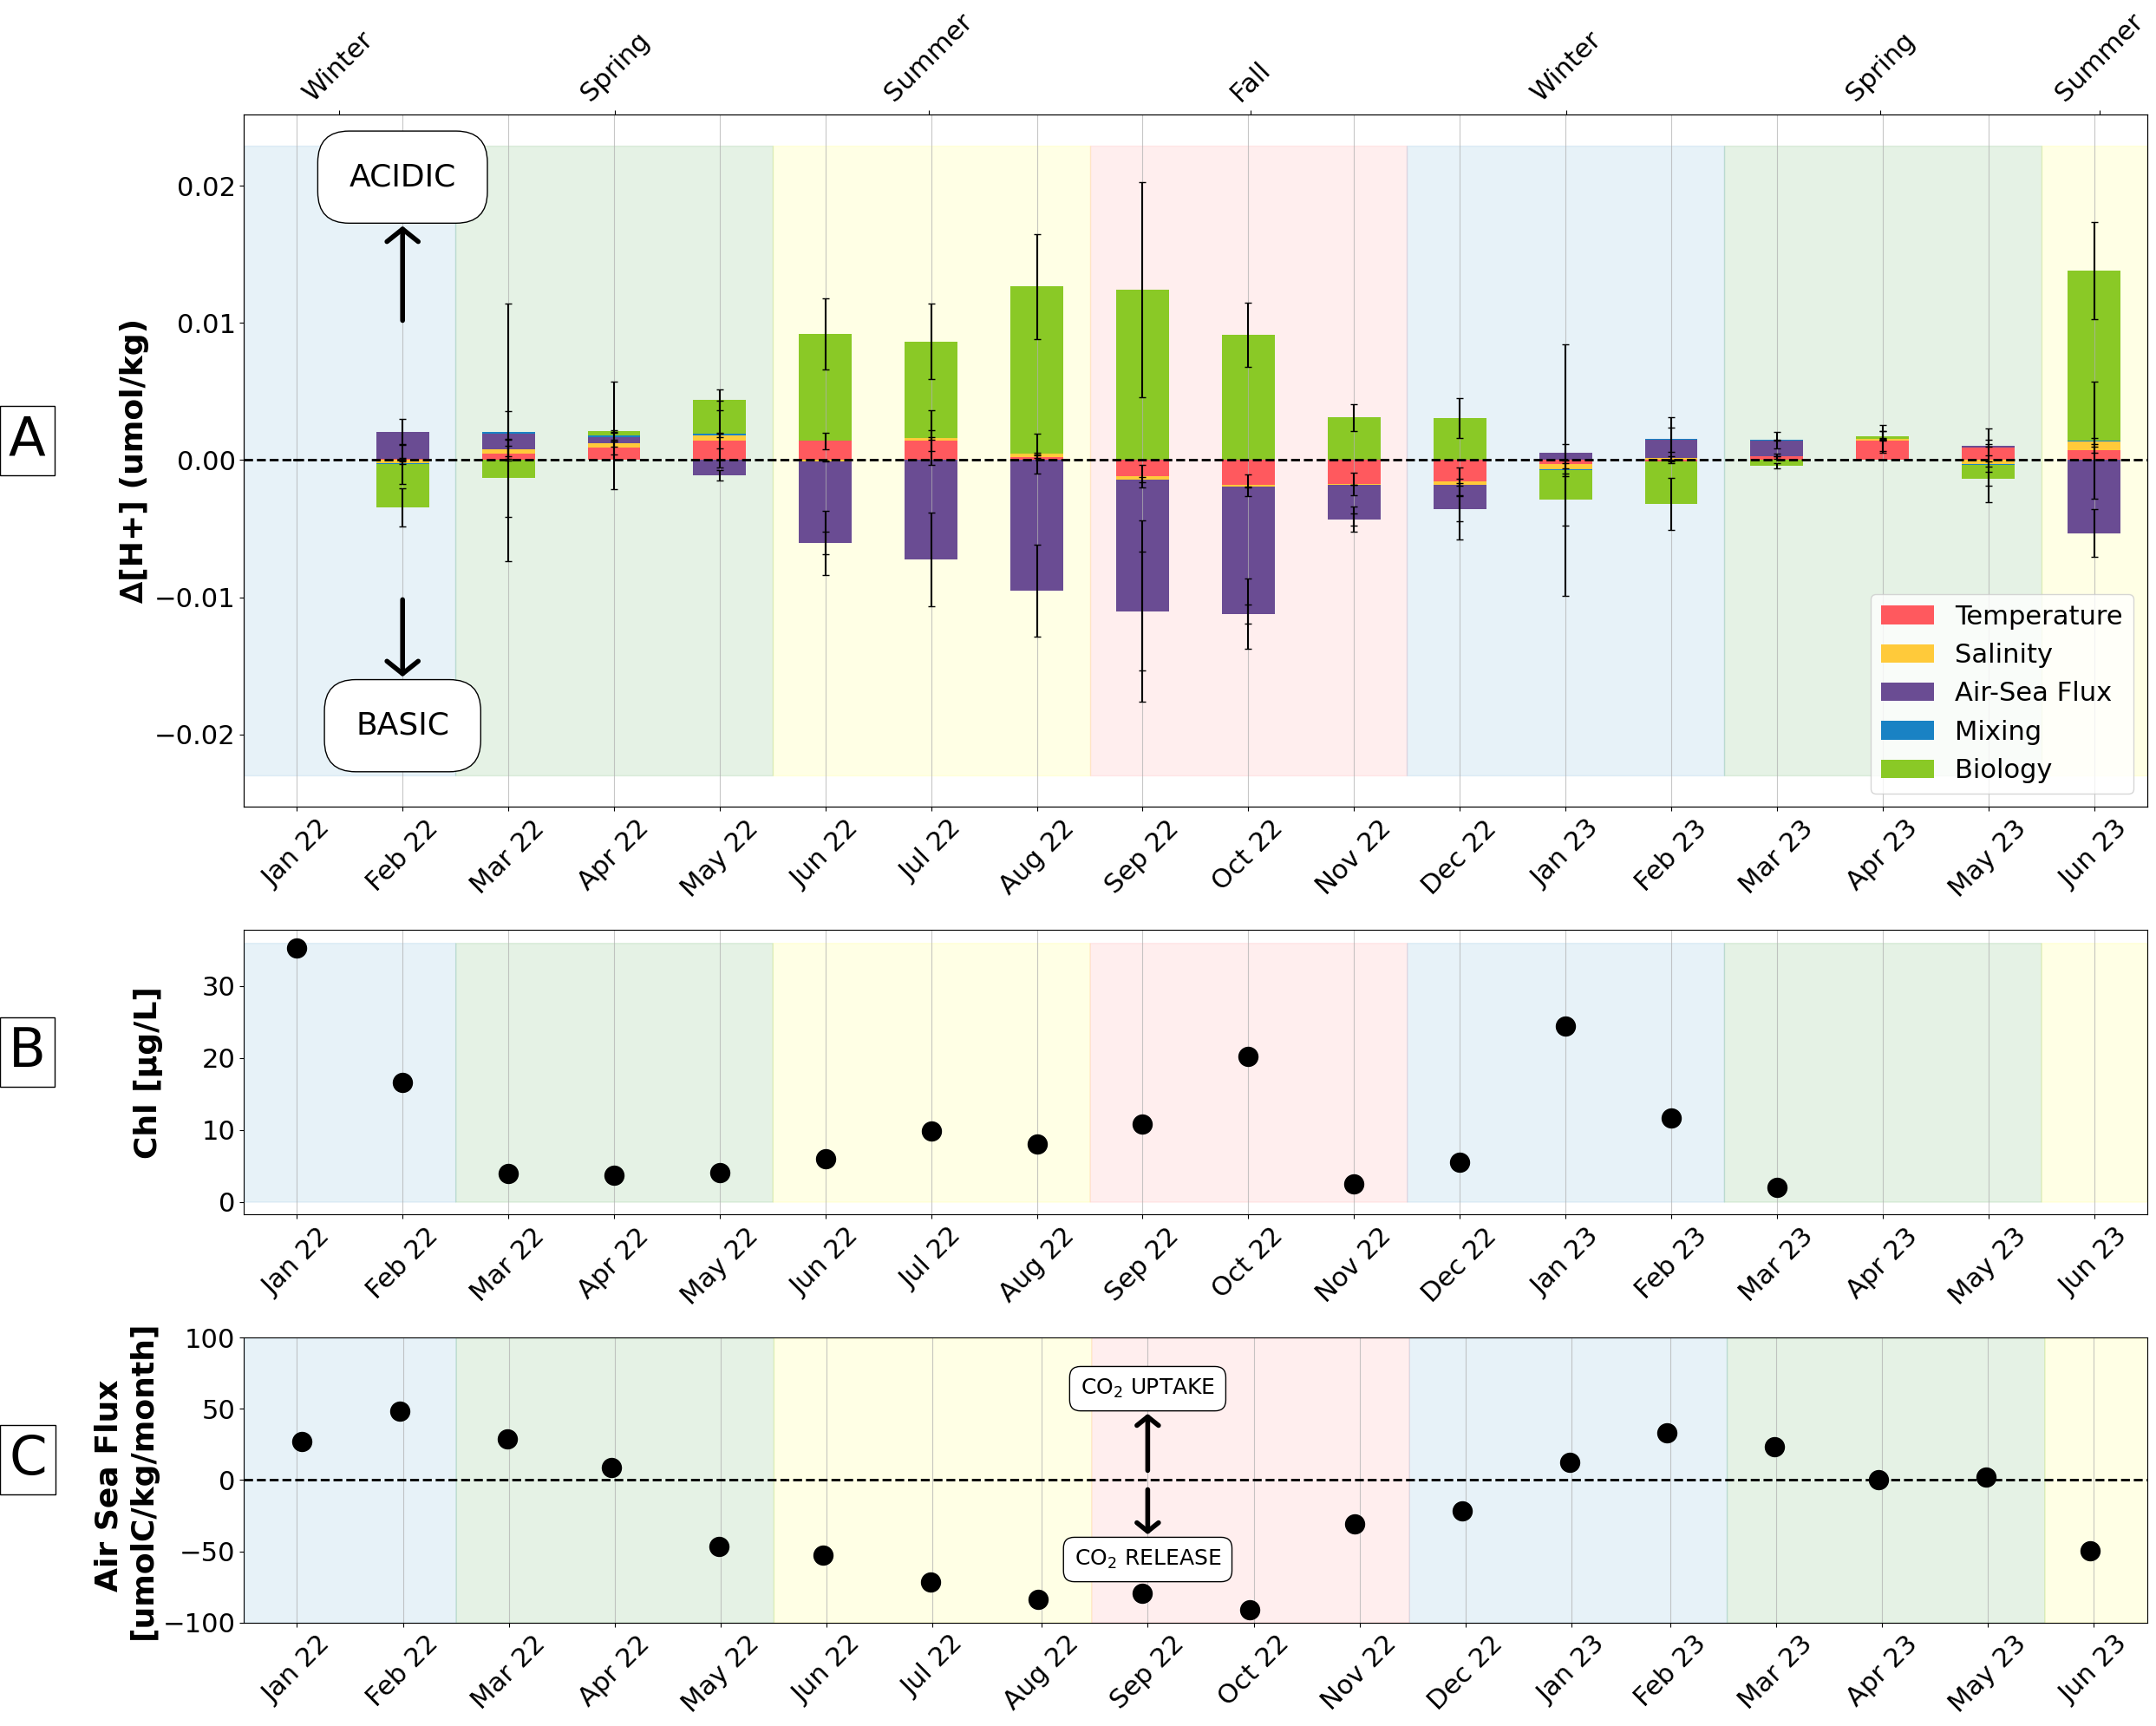

In [167]:
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
fig = plt.figure(figsize = [25,20],tight_layout=True)
gs = gridspec.GridSpec(8, 1)

df = meancomp
dt = meanstd
title = 'Mean of All Sensors'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'Air-Sea Flux': df['DIC air sea flux'],
                     'Mixing': df['Total mixing'],
                     'Biology': df['Total bio']})
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'Air-Sea Flux': dt['DIC ASF'],
                     'Mixing': dt['Total mixing'],
                     'Biology': dt['Total bio']})

# fig, ax = plt.subplots(figsize = [12,8])
ax = fig.add_subplot(gs[0:4, 0])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%b %y'), fontsize = 22);
ax.tick_params('x',labelsize = 22, labelrotation = 45)
ax.tick_params('y',labelsize = 22)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 26, fontweight = 'bold')
ax.set_xlabel('', fontsize = 26)

ax.legend(loc = 'lower right', fontsize = 22)
# ax.set_title(title, fontsize = 18)
ax.grid(axis = 'x', which='major', alpha=0.7) 
ys = np.arange(-0.023,0.023, 0.0001)
ax.fill_betweenx(ys,-4.5+4,-2.5+4, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,-2.5+4,0.5+4, alpha = 0.1, color = 'green', zorder = 0)
ax.fill_betweenx(ys,0.5+4,3.5+4, alpha = 0.1, color = 'yellow', zorder = 0)
ax.fill_betweenx(ys,3.5+4,6.5+4, alpha = 0.1, color = red, zorder = 0)
ax.fill_betweenx(ys,6.5+4,9.5+4, alpha = 0.1, color = blue, zorder = 0)
ax.fill_betweenx(ys,9.5+4,12.5+4, alpha = 0.1, color = 'green', zorder = 0)
ax.fill_betweenx(ys,12.5+4,13.5+4, alpha = 0.1, color = 'yellow', zorder = 0)

plt.annotate('ACIDIC',
             xy=(1,0.01),
             xytext=(1, 0.02), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 26,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.annotate('BASIC',
             xy=(1,-0.01),
             xytext=(1, -0.02), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 26,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

ax2 = ax.twiny()
ax2.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax2.set_xticks([0.05,0.195,0.36,0.529,0.695,0.86,0.975])
ax2.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall', 'Winter', 'Spring', 'Summer'])
ax2.tick_params('x',labelsize = 22, labelrotation = 45)

# ax3 = ax.twinx()
ax3 = fig.add_subplot(gs[4:6, 0])
ax3.set_xlim([-0.5,17.5])
tix = ax.get_xticks()
ax3.set_xticks(tix)
ax3.tick_params('y',labelsize = 22)
ax3.tick_params('x',labelsize = 22, labelrotation = 45)
ax3.set_ylabel('Chl [µg/L]\n', fontsize = 26, fontweight = 'bold')

im2 = ax3.scatter(CHL.index, (CHL['ALL Chl']), 
            facecolor = 'k', edgecolors = 'k', s = 250, label = 'PLT Chlorophyll (surface + bottom)', zorder = 2)
# ax3.set_xticklabels(CHL['Sample Date'].dt.strftime('%b %y'), fontsize = 14);
ax3.set_xticklabels(df.index.strftime('%b %y'), fontsize = 22);
ax3.grid(axis = 'x', which='major', alpha=0.7)
ys = np.arange(0,36, 0.001)
ax3.fill_betweenx(ys,-4.5+4,-2.5+4, alpha = 0.1, color = blue, zorder = 0)
ax3.fill_betweenx(ys,-2.5+4,0.5+4, alpha = 0.1, color = 'green', zorder = 0)
ax3.fill_betweenx(ys,0.5+4,3.5+4, alpha = 0.1, color = 'yellow', zorder = 0)
ax3.fill_betweenx(ys,3.5+4,6.5+4, alpha = 0.1, color = red, zorder = 0)
ax3.fill_betweenx(ys,6.5+4,9.5+4, alpha = 0.1, color = blue, zorder = 0)
ax3.fill_betweenx(ys,9.5+4,12.5+4, alpha = 0.1, color = 'green', zorder = 0)
ax3.fill_betweenx(ys,12.5+4,13.5+4, alpha = 0.1, color = 'yellow', zorder = 0)

ax4 = fig.add_subplot(gs[6:8, 0])

ax4.scatter(meanASF.index, meanASF['DIC air sea flux'],  
           facecolor = 'k', edgecolors = 'k', s = 250, label = 'PLT Chlorophyll (surface + bottom)', zorder = 2)
ax4.set_xticks([19052-30.5, 19052., 19052 + 30.5, 19113., 19113+30.5, 19174., 19174+30.5, 19236., 19236+30.5,
                19297., 19297+30.5, 19358., 19358+30.5, 19417., 19417+30.5, 19478., 19478+30.5,19539])
ax4.set_xlim([19052-1.5*30.5,19539+15.25])
ax4.set_ylim([-100,100])
ax4.tick_params('y',labelsize = 22)
ax4.tick_params('x',labelsize = 22, labelrotation = 45)
ax4.set_ylabel('Air Sea Flux \n[umolC/kg/month]', fontsize = 26, fontweight = 'bold')
ax4.set_xticklabels(meanASF.index.strftime('%b %y'), fontsize = 22);
ax4.grid(axis = 'x', which='major', alpha=0.7)
ax4.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

ys = np.arange(-100,100, 0.001)
x0 = 19052-1.5*30.5
xf = x0 + 61 
ax4.fill_betweenx(ys,19052-1.5*30.5,19052+15.25, alpha = 0.1, color = blue, zorder = 0)
x0 = xf
xf = x0 + 61 + 30.5
ax4.fill_betweenx(ys,x0,xf, alpha = 0.1, color = 'green', zorder = 0)
x0 = xf
xf = x0 + 61 + 30.5
ax4.fill_betweenx(ys,x0,xf, alpha = 0.1, color = 'yellow', zorder = 0)
x0 = xf
xf = x0 + 61 + 30.5
ax4.fill_betweenx(ys,x0,xf, alpha = 0.1, color = red, zorder = 0)
x0 = xf
xf = x0 + 61 + 30.5
ax4.fill_betweenx(ys,x0,xf, alpha = 0.1, color = blue, zorder = 0)
x0 = xf
xf = x0 + 61 + 30.5
ax4.fill_betweenx(ys,x0,xf, alpha = 0.1, color = 'green', zorder = 0)
x0 = xf
xf = x0 + 61 + 30.5
ax4.fill_betweenx(ys,x0,xf, alpha = 0.1, color = 'yellow', zorder = 0)

plt.annotate('CO$_2$ UPTAKE',
             xy=(19236+30.5,5),
             xytext=(19236+30.5, 60), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 18,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.annotate('CO$_2$ RELEASE',
             xy=(19236+30.5,-5),
             xytext=(19236+30.5, -60), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 18,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

import matplotlib.transforms as mtransforms
labs = ['A', '','B', 'C']
i = 0
FS = 30
x = -0.13
y = 0.5
for n,ax in enumerate(fig.axes):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    lab = labs[i]
    ax.text(x, y, lab, transform=ax.transAxes + trans,
            fontsize=FS + 15, verticalalignment='bottom', 
            bbox=dict(facecolor='none', edgecolor='k', pad=7.0))
    i += 1

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H_CHL_ASF.png', bbox_inches='tight')

In [155]:
fig.axes

[<AxesSubplot:xlabel='DateTime', ylabel='∆[H+] (umol/kg)'>,
 <AxesSubplot:>,
 <AxesSubplot:ylabel='Chl [µg/L]\n'>,
 <AxesSubplot:ylabel='Air Sea Flux \n[umolC/kg/month]'>]

In [34]:
# Time Series Chlorophyll spreadsheet
spreadsheet_key = '1BdRyFMxiPv1A-qQj3ajAnZJOr-Sk43osT6BpJaYz248'
#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

# Worksheets
wks_all = 'All Data'
wks_month = 'Monthly'
wks_year = 'Yearly'
wks_avg = 'Avg Chl Month-Year'
wks_std = 'Std Chl Month-Year'
sheet = workbook.worksheet(wks_all)
values = sheet.get_all_values()
chl = pd.DataFrame(values[1:], columns = values[0])

## All chlorophyll
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_all)
values = sheet.get_all_values()
chl = pd.DataFrame(values[1:], columns = values[0])

## Monthly chlorophyll
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_month)
values = sheet.get_all_values()
chl_month = pd.DataFrame(values[1:], columns = values[0])

## Yearly chlorophyll
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_year)
values = sheet.get_all_values()
chl_year = pd.DataFrame(values[1:], columns = values[0])

## Monthly-Yearly Avg chl
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_avg)
values = sheet.get_all_values()
chl_avg = pd.DataFrame(values[1:], columns = values[0])

## Monthly-Yearly Std chl
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_std)
values = sheet.get_all_values()
chl_std = pd.DataFrame(values[1:], columns = values[0])

for k in chl.keys():
    if k == 'Sample Date':
        chl[k] = pd.to_datetime(chl[k])
    elif k != 'Month':
        chl[k] = pd.to_numeric(chl[k])

for k in chl_month.keys():
    if k != 'Sample Date':
        chl_month[k] = pd.to_numeric(chl_month[k])
        
for k in chl_year.keys():
    if k != 'Sample Date':
        chl_year[k] = pd.to_numeric(chl_year[k])
        
for k in chl_avg.keys():
    if k != 'Years':
        chl_avg[k] = pd.to_numeric(chl_avg[k])
        
for k in chl_std.keys():
    if k != 'Years':
        chl_std[k] = pd.to_numeric(chl_std[k])
        
chl_present = chl.where(chl['Sample Date'] >= datetime(2022,1,1)).dropna()
chl_present = chl_present.reset_index(drop=True)
# chl_present = chl_present.set_index('Sample Date')
chl_present

,Month,Sample Date,Surface Chla All (µg/L),Surface Phaeo all (µg/L),Bottom Chla all (µg/L),Bottom Phaeo all (µg/L),surface chla <20 um (µg/L),Surface Phaeo <20 um (µg/L),Bottom Chla <20 um (µg/L),Bottom Phaeo <20 um (µg/L)
0,Jan,2022-01-04,7.61,3.23,7.46,3.71,3.17,2.07,2.49,2.64
1,Jan,2022-01-10,17.55,2.00,16.97,3.31,6.63,2.60,3.43,2.95
2,Jan,2022-01-16,20.39,2.43,20.86,4.82,1.88,2.38,4.65,2.77
3,Jan,2022-01-24,26.17,5.30,19.34,5.99,2.52,2.39,4.74,3.40
4,Jan,2022-01-31,20.13,3.88,20.08,10.75,2.17,3.04,2.48,5.25
5,Feb,2022-02-07,15.24,4.47,14.77,5.63,3.26,5.07,2.15,3.55
6,Feb,2022-02-15,10.43,3.22,6.44,4.35,1.98,2.33,1.32,3.21
7,Feb,2022-02-21,2.50,4.31,2.18,3.96,0.99,2.90,0.74,2.84
8,Feb,2022-02-28,7.76,3.15,7.22,4.00,1.81,2.18,1.41,2.70
9,Mar,2022-03-07,1.15,1.73,1.40,2.10,0.59,1.54,0.79,1.74


In [35]:
chl_present = chl_present.set_index('Sample Date')
CHL = chl_present.groupby(pd.Grouper(freq="M")).mean()

In [36]:
CHL['ALL Chl'] = CHL['Surface Chla All (µg/L)'] + CHL['Bottom Chla all (µg/L)']
CHL = CHL.reset_index()

In [37]:
CHL['Sample Date'].dt.strftime()

TypeError: strftime() missing 1 required positional argument: 'date_format'